In [1]:
# My 3rd competition, help me oh Lord

In [2]:
#importing all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 


In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('SampleSubmission.csv')
desp = pd.read_csv('VariableDescription.csv')

In [4]:
train.head(3)

,BCT_CODBUR,CTR_MATFIS,CTR_CATEGO_X,FJU_CODFJU,CTR_CESSAT,ACT_CODACT,CTR_OBLDIR,CTR_OBLACP,CTR_OBLRES,CTR_OBLFOP,...,target,FAC_MNTPRI_F,FAC_MFODEC_F,FAC_MNTDCO_F,FAC_MNTTVA_F,FAC_MNTPRI_C,FAC_MFODEC_C,FAC_MNTDCO_C,FAC_MNTTVA_C,id
0,49,14185,P,99,1,6101,4,2,2,2,...,13.575957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train_id0
1,221,6032,P,99,0,6271,8,2,1,1,...,11.692894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train_id1
2,181,8907,P,99,0,6102,4,2,2,2,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train_id2


In [5]:
test.head(1)

,BCT_CODBUR,CTR_MATFIS,CTR_CATEGO_X,FJU_CODFJU,CTR_CESSAT,ACT_CODACT,CTR_OBLDIR,CTR_OBLACP,CTR_OBLRES,CTR_OBLFOP,...,RES_ANNIMP,FAC_MNTPRI_F,FAC_MFODEC_F,FAC_MNTDCO_F,FAC_MNTTVA_F,FAC_MNTPRI_C,FAC_MFODEC_C,FAC_MNTDCO_C,FAC_MNTTVA_C,id
0,9,11802,P,99,0,6306,8,2,2,2,...,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test_id0


In [6]:
print train.shape
print test.shape

(25053, 121)
(10738, 120)


In [7]:
desp.head(1)

,Libellé,Intitulé,Title
0,Contribuable,NaN,Rate payer


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25053 entries, 0 to 25052
Columns: 121 entries, BCT_CODBUR to id
dtypes: float64(103), int64(16), object(2)
memory usage: 23.1+ MB


## Dealing with missing data

In [10]:
#some columns having too much missing datas and some with redundants input
to_drop = [columns for columns in train.columns[train.isnull().mean()>=0.7]]
to_drop.extend([columns for columns in train.columns if columns not in ['id','CTR_CATEGO_X']
                if train[columns].std() == 0])
to_drop.append('id')
train.drop(to_drop, axis=1, inplace=True)
test.drop(to_drop, axis=1, inplace=True)
print("%f columns were dropped"%(len(to_drop)))

41.000000 columns were dropped


In [11]:
#the only object type left
train['CTR_CATEGO_X'] = train['CTR_CATEGO_X'].factorize()[0]
test['CTR_CATEGO_X'] = test['CTR_CATEGO_X'].factorize()[0]

In [12]:
#filling the remaining missing data
for col in train.columns:
    train[col].fillna(train[col].mean(),inplace= True)
for col in test.columns:
    test[col].fillna(test[col].mean(),inplace= True)

## Feature Engineering

In [13]:
train['RES_ANNIMP'] = 2020-train['RES_ANNIMP']
test['RES_ANNIMP'] = 2020-test['RES_ANNIMP']

In [14]:
#this columns were gotten from feature_importance of catboost running on train
#param_used = (n_estimators=5000,max_depth=10,eval_metric='RMSE',reg_lambda=50,random_state=43)
#this columns can gradually be reduced/increased to boost the score
less_impor= ['RES_ANNIMP','CTR_CATEGO_X', 'CTR_OBLDLI', 'TVA_BASAUI','TVA_DEDEQL','TVA_BASEQL','TVA_MOIDEB','CTR_OBLACP','TVA_DEDREG','TVA_CHAF22','CTR_OBLTVA','TVA_DEDEQI','TVA_BASEQI','CTR_OBLDIR',
 'TVA_MACHN','CTR_OFODEC','TVA_RSNRES','TVA_TRSPOR','TVA_MTDJRTVA','TVA_ACHEXO','CTR_OBLTHO','TVA_MCESQ','CTR_RATISS','TVA_CHAF15','TVA_CRDRMP',
 'TVA_CHAFF7','TVA_MTALSM','CTR_OFODEP','TVA_TXALSM','TVA_BASIMB','TVA_DEDIMB','CTR_OBLTFP','CTR_OFODET','CTR_OBLTCL','TVA_ACHNDD','TVA_CRDRES','TVA_CA192018',
 'CTR_OBLASS','TVA_MTVLSM','TVA_CRDRMC','TVA_CA072018','CTR_OBLDCO','TVA_MTDJRTAX','TVA_TXVLSM','TVA_ACHSUS','CTR_OBLAUT','TVA_CA132018','CTR_OBLRES',
 'TVA_MTRESTAX','TVA_CHAF10','TVA_AACHAB','TVA_MTORDTVA','TVA_CHAF29','TVA_CRDBLQ','CTR_OBLTVI']

In [15]:
#dropping unimportant features
train = train.drop(less_impor,axis=1)
test = test.drop(less_impor,axis=1)

In [16]:
#scaling the data
from sklearn.preprocessing import RobustScaler
RS = RobustScaler()
train_trans = RS.fit_transform(train.drop(['target'], axis = 1))
test_trans = RS.transform(test)

In [17]:
train_trans

array([[-0.82098765,  0.81786632,  0.98701299, ...,  0.        ,
         0.14267404, -0.05435067],
       [ 0.24074074, -0.23007712,  0.98701299, ...,  0.        ,
         0.61593823, -0.05435067],
       [-0.00617284,  0.13946015,  0.98701299, ...,  1.        ,
         1.        ,  0.94564933],
       ...,
       [ 1.39506173,  0.60912596,  0.98701299, ...,  0.        ,
         0.02366367, -0.05435067],
       [ 1.41975309, -0.32159383,  0.98701299, ...,  0.        ,
         0.        , -0.05435067],
       [ 1.37037037, -0.89768638, -0.01298701, ...,  1.        ,
         1.        ,  0.94564933]])

In [18]:
y= train['target']
X = train_trans

## Modelling

In [156]:
kf = KFold(n_splits=10,random_state=43,shuffle=True)
scores = []
test_scores = np.zeros(len(test_trans))
for fold,(tr_in,te_in) in enumerate(kf.split(X)):
    print("=============================Fold{fold}=================================".format(fold=fold))
    X_train,X_test = X[tr_in],X[te_in]
    y_train,y_test = y.iloc[tr_in],y.iloc[te_in]
    xgbreg = XGBRegressor(n_estimators=5000, learning_rate=0.044, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=10,random_state = 43,min_child_wweight = 12)

    xgbreg.fit(X_train,y_train)
    scores.append(np.sqrt(mean_squared_error(y_test,xgbreg.predict(X_test))))
    test_scores += xgbreg.predict(test_trans)

================================Fold0====================================
================================Fold1====================================
================================Fold2====================================
================================Fold3====================================
================================Fold4====================================
================================Fold5====================================
================================Fold6====================================
================================Fold7====================================
================================Fold8====================================
================================Fold9====================================


In [157]:
np.mean(scores)#5.59

5.596549737674491

In [158]:
xgb_pred = test_scores/10

In [162]:
submission['target'] = np.round(xgb_pred)

In [160]:
submission.to_csv('subX5.csv',index=False)

In [20]:
kf = KFold(n_splits=10,random_state=43,shuffle=True)
scores_lgb = []
test_scores_lgb = np.zeros(len(test_trans))
for fold,(tr_in,te_in) in enumerate(kf.split(X)):
    print("============================Fold{fold}================================".format(fold=fold))
    X_train,X_test = X[tr_in],X[te_in]
    y_train,y_test = y.iloc[tr_in],y.iloc[te_in]
    lgb = LGBMRegressor(n_estimators=5000, learning_rate=0.044, gamma=0, subsample=0.75,
                           colsample_bytree=0.75, max_depth=15,random_state = 7,
                        min_child_weight = 12,silent = True)
    lgb.fit(X_train,y_train)
    scores_lgb.append(np.sqrt(mean_squared_error(y_test,lgb.predict(X_test))))
    test_scores_lgb += lgb.predict(test_trans)

============================Fold0================================
============================Fold1================================
============================Fold2================================
============================Fold3================================
============================Fold4================================
============================Fold5================================
============================Fold6================================
============================Fold7================================
============================Fold8================================
============================Fold9================================


In [22]:
np.mean(scores_lgb)#5.69

5.693539288095688

In [23]:
lgb_pred = test_scores_lgb / 10
lgb_pred1 = lgb.predict(test_trans)

In [24]:
submission['target'] = lgb_pred

In [25]:
submission.to_csv('subltg.csv',index=False)

In [ ]:
kf = KFold(n_splits=10,random_state=43,shuffle=True)
scores = []
test_scores1 = np.zeros(len(test_trans))
for fold,(tr_in,te_in) in enumerate(kf.split(X)):
    print("================================Fold{fold}====================================".format(fold=fold))
    X_train,X_test = X[tr_in],X[te_in]
    y_train,y_test = y.iloc[tr_in],y.iloc[te_in]

    cat = CatBoostRegressor(n_estimators=5000,max_depth=10,eval_metric='RMSE',reg_lambda=50,random_state=43)
    cat.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],early_stopping_rounds=500,use_best_model=True)
    scores.append(np.sqrt(mean_squared_error(y_test,cat.predict(X_test))))
    test_scores1 += cat.predict(test_trans)

================================Fold0====================================
0:	learn: 7.0485564	test: 7.0485564	test1: 6.9992714	best: 6.9992714 (0)	total: 1.57s	remaining: 2h 10m 59s
1:	learn: 7.0150860	test: 7.0150860	test1: 6.9665712	best: 6.9665712 (1)	total: 2.18s	remaining: 1h 30m 55s
2:	learn: 6.9817792	test: 6.9817792	test1: 6.9346342	best: 6.9346342 (2)	total: 2.72s	remaining: 1h 15m 34s
3:	learn: 6.9517061	test: 6.9517061	test1: 6.9049875	best: 6.9049875 (3)	total: 3.2s	remaining: 1h 6m 34s
4:	learn: 6.9241403	test: 6.9241403	test1: 6.8776210	best: 6.8776210 (4)	total: 3.65s	remaining: 1h 45s
5:	learn: 6.8957807	test: 6.8957807	test1: 6.8509758	best: 6.8509758 (5)	total: 4.06s	remaining: 56m 21s
6:	learn: 6.8703339	test: 6.8703339	test1: 6.8264378	best: 6.8264378 (6)	total: 4.47s	remaining: 53m 10s
7:	learn: 6.8438577	test: 6.8438577	test1: 6.8007036	best: 6.8007036 (7)	total: 4.83s	remaining: 50m 15s
8:	learn: 6.8195977	test: 6.8195977	test1: 6.7775401	best: 6.7775401 (8)	tota

77:	learn: 6.1732595	test: 6.1732595	test1: 6.2175207	best: 6.2175207 (77)	total: 36.2s	remaining: 38m 6s
78:	learn: 6.1696766	test: 6.1696766	test1: 6.2157994	best: 6.2157994 (78)	total: 36.9s	remaining: 38m 21s
79:	learn: 6.1662095	test: 6.1662095	test1: 6.2134296	best: 6.2134296 (79)	total: 37.5s	remaining: 38m 28s
80:	learn: 6.1622932	test: 6.1622932	test1: 6.2109851	best: 6.2109851 (80)	total: 38s	remaining: 38m 24s
81:	learn: 6.1590847	test: 6.1590847	test1: 6.2088419	best: 6.2088419 (81)	total: 38.3s	remaining: 38m 14s
82:	learn: 6.1559104	test: 6.1559104	test1: 6.2063492	best: 6.2063492 (82)	total: 38.5s	remaining: 38m 3s
83:	learn: 6.1527139	test: 6.1527139	test1: 6.2043302	best: 6.2043302 (83)	total: 39s	remaining: 37m 59s
84:	learn: 6.1494321	test: 6.1494321	test1: 6.2020334	best: 6.2020334 (84)	total: 39.3s	remaining: 37m 52s
85:	learn: 6.1457295	test: 6.1457295	test1: 6.1995575	best: 6.1995575 (85)	total: 39.7s	remaining: 37m 46s
86:	learn: 6.1424988	test: 6.1424988	test1:

153:	learn: 6.0072597	test: 6.0072597	test1: 6.1282346	best: 6.1282346 (153)	total: 1m 9s	remaining: 36m 41s
154:	learn: 6.0055325	test: 6.0055325	test1: 6.1271441	best: 6.1271441 (154)	total: 1m 10s	remaining: 36m 35s
155:	learn: 6.0040449	test: 6.0040449	test1: 6.1266138	best: 6.1266138 (155)	total: 1m 10s	remaining: 36m 34s
156:	learn: 6.0024127	test: 6.0024127	test1: 6.1261867	best: 6.1261867 (156)	total: 1m 11s	remaining: 36m 32s
157:	learn: 6.0001467	test: 6.0001467	test1: 6.1250686	best: 6.1250686 (157)	total: 1m 11s	remaining: 36m 37s
158:	learn: 5.9982868	test: 5.9982868	test1: 6.1244879	best: 6.1244879 (158)	total: 1m 12s	remaining: 36m 41s
159:	learn: 5.9960343	test: 5.9960343	test1: 6.1235680	best: 6.1235680 (159)	total: 1m 12s	remaining: 36m 45s
160:	learn: 5.9947048	test: 5.9947048	test1: 6.1228698	best: 6.1228698 (160)	total: 1m 13s	remaining: 36m 50s
161:	learn: 5.9927272	test: 5.9927272	test1: 6.1224339	best: 6.1224339 (161)	total: 1m 14s	remaining: 36m 54s
162:	learn:

228:	learn: 5.8982839	test: 5.8982839	test1: 6.0889342	best: 6.0889342 (228)	total: 1m 48s	remaining: 37m 49s
229:	learn: 5.8969420	test: 5.8969420	test1: 6.0887970	best: 6.0887970 (229)	total: 1m 49s	remaining: 37m 51s
230:	learn: 5.8959125	test: 5.8959125	test1: 6.0880575	best: 6.0880575 (230)	total: 1m 50s	remaining: 37m 53s
231:	learn: 5.8950138	test: 5.8950138	test1: 6.0881909	best: 6.0880575 (230)	total: 1m 50s	remaining: 37m 53s
232:	learn: 5.8937456	test: 5.8937456	test1: 6.0874846	best: 6.0874846 (232)	total: 1m 51s	remaining: 37m 51s
233:	learn: 5.8929199	test: 5.8929199	test1: 6.0873345	best: 6.0873345 (233)	total: 1m 51s	remaining: 37m 51s
234:	learn: 5.8918742	test: 5.8918742	test1: 6.0866825	best: 6.0866825 (234)	total: 1m 52s	remaining: 37m 52s
235:	learn: 5.8906131	test: 5.8906131	test1: 6.0857015	best: 6.0857015 (235)	total: 1m 52s	remaining: 37m 50s
236:	learn: 5.8889143	test: 5.8889143	test1: 6.0853377	best: 6.0853377 (236)	total: 1m 52s	remaining: 37m 47s
237:	learn

303:	learn: 5.8126363	test: 5.8126363	test1: 6.0608783	best: 6.0604682 (302)	total: 2m 27s	remaining: 37m 51s
304:	learn: 5.8119516	test: 5.8119516	test1: 6.0605007	best: 6.0604682 (302)	total: 2m 27s	remaining: 37m 48s
305:	learn: 5.8110272	test: 5.8110272	test1: 6.0599122	best: 6.0599122 (305)	total: 2m 27s	remaining: 37m 44s
306:	learn: 5.8098570	test: 5.8098570	test1: 6.0595224	best: 6.0595224 (306)	total: 2m 27s	remaining: 37m 41s
307:	learn: 5.8094535	test: 5.8094535	test1: 6.0594789	best: 6.0594789 (307)	total: 2m 28s	remaining: 37m 39s
308:	learn: 5.8086428	test: 5.8086428	test1: 6.0590847	best: 6.0590847 (308)	total: 2m 28s	remaining: 37m 40s
309:	learn: 5.8078867	test: 5.8078867	test1: 6.0589460	best: 6.0589460 (309)	total: 2m 29s	remaining: 37m 42s
310:	learn: 5.8066462	test: 5.8066462	test1: 6.0585383	best: 6.0585383 (310)	total: 2m 30s	remaining: 37m 43s
311:	learn: 5.8060532	test: 5.8060532	test1: 6.0585884	best: 6.0585383 (310)	total: 2m 30s	remaining: 37m 44s
312:	learn

378:	learn: 5.7492855	test: 5.7492855	test1: 6.0385962	best: 6.0385962 (378)	total: 3m 4s	remaining: 37m 30s
379:	learn: 5.7482765	test: 5.7482765	test1: 6.0378550	best: 6.0378550 (379)	total: 3m 4s	remaining: 37m 28s
380:	learn: 5.7481247	test: 5.7481247	test1: 6.0377341	best: 6.0377341 (380)	total: 3m 5s	remaining: 37m 26s
381:	learn: 5.7471106	test: 5.7471106	test1: 6.0376309	best: 6.0376309 (381)	total: 3m 5s	remaining: 37m 24s
382:	learn: 5.7464953	test: 5.7464953	test1: 6.0370080	best: 6.0370080 (382)	total: 3m 5s	remaining: 37m 22s
383:	learn: 5.7456334	test: 5.7456334	test1: 6.0362600	best: 6.0362600 (383)	total: 3m 6s	remaining: 37m 19s
384:	learn: 5.7448513	test: 5.7448513	test1: 6.0361787	best: 6.0361787 (384)	total: 3m 6s	remaining: 37m 17s
385:	learn: 5.7440389	test: 5.7440389	test1: 6.0358365	best: 6.0358365 (385)	total: 3m 6s	remaining: 37m 15s
386:	learn: 5.7438796	test: 5.7438796	test1: 6.0357738	best: 6.0357738 (386)	total: 3m 7s	remaining: 37m 12s
387:	learn: 5.74296

453:	learn: 5.7074199	test: 5.7074199	test1: 6.0220576	best: 6.0220576 (453)	total: 3m 42s	remaining: 37m 12s
454:	learn: 5.7073282	test: 5.7073282	test1: 6.0219600	best: 6.0219600 (454)	total: 3m 43s	remaining: 37m 14s
455:	learn: 5.7067633	test: 5.7067633	test1: 6.0217504	best: 6.0217504 (455)	total: 3m 44s	remaining: 37m 15s
456:	learn: 5.7061538	test: 5.7061538	test1: 6.0215605	best: 6.0215605 (456)	total: 3m 45s	remaining: 37m 17s
457:	learn: 5.7050622	test: 5.7050622	test1: 6.0206338	best: 6.0206338 (457)	total: 3m 45s	remaining: 37m 18s
458:	learn: 5.7044498	test: 5.7044498	test1: 6.0206492	best: 6.0206338 (457)	total: 3m 46s	remaining: 37m 18s
459:	learn: 5.7037139	test: 5.7037139	test1: 6.0203673	best: 6.0203673 (459)	total: 3m 46s	remaining: 37m 19s
460:	learn: 5.7030052	test: 5.7030052	test1: 6.0200902	best: 6.0200902 (460)	total: 3m 47s	remaining: 37m 20s
461:	learn: 5.7010888	test: 5.7010888	test1: 6.0191983	best: 6.0191983 (461)	total: 3m 48s	remaining: 37m 21s
462:	learn

529:	learn: 5.6557644	test: 5.6557644	test1: 6.0029069	best: 6.0029069 (529)	total: 4m 25s	remaining: 37m 16s
530:	learn: 5.6556876	test: 5.6556876	test1: 6.0028769	best: 6.0028769 (530)	total: 4m 25s	remaining: 37m 17s
531:	learn: 5.6546183	test: 5.6546183	test1: 6.0023743	best: 6.0023743 (531)	total: 4m 26s	remaining: 37m 17s
532:	learn: 5.6538815	test: 5.6538815	test1: 6.0019397	best: 6.0019397 (532)	total: 4m 26s	remaining: 37m 16s
533:	learn: 5.6531155	test: 5.6531155	test1: 6.0015814	best: 6.0015814 (533)	total: 4m 27s	remaining: 37m 14s
534:	learn: 5.6525799	test: 5.6525799	test1: 6.0016192	best: 6.0015814 (533)	total: 4m 27s	remaining: 37m 13s
535:	learn: 5.6513700	test: 5.6513700	test1: 6.0012820	best: 6.0012820 (535)	total: 4m 28s	remaining: 37m 12s
536:	learn: 5.6502848	test: 5.6502848	test1: 6.0008446	best: 6.0008446 (536)	total: 4m 28s	remaining: 37m 10s
537:	learn: 5.6493442	test: 5.6493442	test1: 6.0007020	best: 6.0007020 (537)	total: 4m 28s	remaining: 37m 9s
538:	learn:

604:	learn: 5.6057496	test: 5.6057496	test1: 5.9845121	best: 5.9845121 (604)	total: 5m 1s	remaining: 36m 28s
605:	learn: 5.6047478	test: 5.6047478	test1: 5.9840874	best: 5.9840874 (605)	total: 5m 1s	remaining: 36m 28s
606:	learn: 5.6045289	test: 5.6045289	test1: 5.9839541	best: 5.9839541 (606)	total: 5m 2s	remaining: 36m 26s
607:	learn: 5.6044689	test: 5.6044689	test1: 5.9839344	best: 5.9839344 (607)	total: 5m 2s	remaining: 36m 25s
608:	learn: 5.6038726	test: 5.6038726	test1: 5.9838509	best: 5.9838509 (608)	total: 5m 2s	remaining: 36m 24s
609:	learn: 5.6033363	test: 5.6033363	test1: 5.9837241	best: 5.9837241 (609)	total: 5m 3s	remaining: 36m 22s
610:	learn: 5.6018914	test: 5.6018914	test1: 5.9831532	best: 5.9831532 (610)	total: 5m 3s	remaining: 36m 20s
611:	learn: 5.6012035	test: 5.6012035	test1: 5.9830514	best: 5.9830514 (611)	total: 5m 3s	remaining: 36m 19s
612:	learn: 5.6006476	test: 5.6006476	test1: 5.9826264	best: 5.9826264 (612)	total: 5m 4s	remaining: 36m 17s
613:	learn: 5.59970

679:	learn: 5.5597151	test: 5.5597151	test1: 5.9690170	best: 5.9690170 (679)	total: 5m 37s	remaining: 35m 43s
680:	learn: 5.5596616	test: 5.5596616	test1: 5.9689769	best: 5.9689769 (680)	total: 5m 38s	remaining: 35m 43s
681:	learn: 5.5588125	test: 5.5588125	test1: 5.9684965	best: 5.9684965 (681)	total: 5m 38s	remaining: 35m 43s
682:	learn: 5.5587445	test: 5.5587445	test1: 5.9685176	best: 5.9684965 (681)	total: 5m 39s	remaining: 35m 44s
683:	learn: 5.5581059	test: 5.5581059	test1: 5.9684343	best: 5.9684343 (683)	total: 5m 39s	remaining: 35m 44s
684:	learn: 5.5568845	test: 5.5568845	test1: 5.9679192	best: 5.9679192 (684)	total: 5m 40s	remaining: 35m 44s
685:	learn: 5.5566184	test: 5.5566184	test1: 5.9677926	best: 5.9677926 (685)	total: 5m 40s	remaining: 35m 44s
686:	learn: 5.5565660	test: 5.5565660	test1: 5.9677629	best: 5.9677629 (686)	total: 5m 41s	remaining: 35m 42s
687:	learn: 5.5555852	test: 5.5555852	test1: 5.9675194	best: 5.9675194 (687)	total: 5m 41s	remaining: 35m 40s
688:	learn

754:	learn: 5.5160436	test: 5.5160436	test1: 5.9565174	best: 5.9565174 (754)	total: 6m 16s	remaining: 35m 18s
755:	learn: 5.5155178	test: 5.5155178	test1: 5.9562745	best: 5.9562745 (755)	total: 6m 17s	remaining: 35m 18s
756:	learn: 5.5152876	test: 5.5152876	test1: 5.9562579	best: 5.9562579 (756)	total: 6m 17s	remaining: 35m 18s
757:	learn: 5.5151346	test: 5.5151346	test1: 5.9561609	best: 5.9561609 (757)	total: 6m 18s	remaining: 35m 18s
758:	learn: 5.5146144	test: 5.5146144	test1: 5.9559307	best: 5.9559307 (758)	total: 6m 19s	remaining: 35m 18s
759:	learn: 5.5135620	test: 5.5135620	test1: 5.9556768	best: 5.9556768 (759)	total: 6m 19s	remaining: 35m 16s
760:	learn: 5.5127895	test: 5.5127895	test1: 5.9555984	best: 5.9555984 (760)	total: 6m 19s	remaining: 35m 14s
761:	learn: 5.5121330	test: 5.5121330	test1: 5.9552707	best: 5.9552707 (761)	total: 6m 20s	remaining: 35m 14s
762:	learn: 5.5120579	test: 5.5120579	test1: 5.9552422	best: 5.9552422 (762)	total: 6m 21s	remaining: 35m 17s
763:	learn

829:	learn: 5.4682475	test: 5.4682475	test1: 5.9445380	best: 5.9445380 (829)	total: 7m 4s	remaining: 35m 30s
830:	learn: 5.4680789	test: 5.4680789	test1: 5.9443201	best: 5.9443201 (830)	total: 7m 4s	remaining: 35m 30s
831:	learn: 5.4670498	test: 5.4670498	test1: 5.9437041	best: 5.9437041 (831)	total: 7m 5s	remaining: 35m 31s
832:	learn: 5.4662541	test: 5.4662541	test1: 5.9432617	best: 5.9432617 (832)	total: 7m 6s	remaining: 35m 31s
833:	learn: 5.4658177	test: 5.4658177	test1: 5.9431454	best: 5.9431454 (833)	total: 7m 6s	remaining: 35m 32s
834:	learn: 5.4657623	test: 5.4657623	test1: 5.9431256	best: 5.9431256 (834)	total: 7m 7s	remaining: 35m 33s
835:	learn: 5.4654702	test: 5.4654702	test1: 5.9431336	best: 5.9431256 (834)	total: 7m 8s	remaining: 35m 33s
836:	learn: 5.4654225	test: 5.4654225	test1: 5.9430783	best: 5.9430783 (836)	total: 7m 9s	remaining: 35m 34s
837:	learn: 5.4650351	test: 5.4650351	test1: 5.9429723	best: 5.9429723 (837)	total: 7m 9s	remaining: 35m 33s
838:	learn: 5.46423

904:	learn: 5.4297840	test: 5.4297840	test1: 5.9326819	best: 5.9326819 (904)	total: 7m 46s	remaining: 35m 10s
905:	learn: 5.4296483	test: 5.4296483	test1: 5.9325124	best: 5.9325124 (905)	total: 7m 46s	remaining: 35m 9s
906:	learn: 5.4289940	test: 5.4289940	test1: 5.9322635	best: 5.9322635 (906)	total: 7m 47s	remaining: 35m 8s
907:	learn: 5.4286496	test: 5.4286496	test1: 5.9322540	best: 5.9322540 (907)	total: 7m 47s	remaining: 35m 6s
908:	learn: 5.4275330	test: 5.4275330	test1: 5.9320832	best: 5.9320832 (908)	total: 7m 47s	remaining: 35m 5s
909:	learn: 5.4274190	test: 5.4274190	test1: 5.9319522	best: 5.9319522 (909)	total: 7m 48s	remaining: 35m 3s
910:	learn: 5.4270157	test: 5.4270157	test1: 5.9317527	best: 5.9317527 (910)	total: 7m 48s	remaining: 35m 2s
911:	learn: 5.4267061	test: 5.4267061	test1: 5.9316712	best: 5.9316712 (911)	total: 7m 48s	remaining: 35m 2s
912:	learn: 5.4262226	test: 5.4262226	test1: 5.9316691	best: 5.9316691 (912)	total: 7m 49s	remaining: 35m 2s
913:	learn: 5.4255

979:	learn: 5.3956244	test: 5.3956244	test1: 5.9238914	best: 5.9238601 (978)	total: 8m 28s	remaining: 34m 45s
980:	learn: 5.3955527	test: 5.3955527	test1: 5.9238147	best: 5.9238147 (980)	total: 8m 29s	remaining: 34m 45s
981:	learn: 5.3944518	test: 5.3944518	test1: 5.9235604	best: 5.9235604 (981)	total: 8m 29s	remaining: 34m 45s
982:	learn: 5.3933614	test: 5.3933614	test1: 5.9233537	best: 5.9233537 (982)	total: 8m 30s	remaining: 34m 44s
983:	learn: 5.3932259	test: 5.3932259	test1: 5.9233448	best: 5.9233448 (983)	total: 8m 30s	remaining: 34m 43s
984:	learn: 5.3930790	test: 5.3930790	test1: 5.9232773	best: 5.9232773 (984)	total: 8m 31s	remaining: 34m 43s
985:	learn: 5.3925742	test: 5.3925742	test1: 5.9231110	best: 5.9231110 (985)	total: 8m 31s	remaining: 34m 41s
986:	learn: 5.3913374	test: 5.3913374	test1: 5.9226929	best: 5.9226929 (986)	total: 8m 31s	remaining: 34m 40s
987:	learn: 5.3912849	test: 5.3912849	test1: 5.9226572	best: 5.9226572 (987)	total: 8m 32s	remaining: 34m 39s
988:	learn

1053:	learn: 5.3628537	test: 5.3628537	test1: 5.9156034	best: 5.9155571 (1052)	total: 9m 5s	remaining: 34m 3s
1054:	learn: 5.3616604	test: 5.3616604	test1: 5.9154403	best: 5.9154403 (1054)	total: 9m 6s	remaining: 34m 2s
1055:	learn: 5.3611815	test: 5.3611815	test1: 5.9152070	best: 5.9152070 (1055)	total: 9m 6s	remaining: 34m
1056:	learn: 5.3601474	test: 5.3601474	test1: 5.9151773	best: 5.9151773 (1056)	total: 9m 6s	remaining: 33m 59s
1057:	learn: 5.3588608	test: 5.3588608	test1: 5.9147038	best: 5.9147038 (1057)	total: 9m 7s	remaining: 33m 59s
1058:	learn: 5.3586983	test: 5.3586983	test1: 5.9146009	best: 5.9146009 (1058)	total: 9m 8s	remaining: 33m 59s
1059:	learn: 5.3579106	test: 5.3579106	test1: 5.9142412	best: 5.9142412 (1059)	total: 9m 8s	remaining: 33m 59s
1060:	learn: 5.3578544	test: 5.3578544	test1: 5.9142583	best: 5.9142412 (1059)	total: 9m 9s	remaining: 34m
1061:	learn: 5.3571486	test: 5.3571486	test1: 5.9139096	best: 5.9139096 (1061)	total: 9m 10s	remaining: 34m
1062:	learn: 5

1127:	learn: 5.3234583	test: 5.3234583	test1: 5.9048578	best: 5.9048578 (1127)	total: 9m 44s	remaining: 33m 26s
1128:	learn: 5.3228895	test: 5.3228895	test1: 5.9048096	best: 5.9048096 (1128)	total: 9m 45s	remaining: 33m 26s
1129:	learn: 5.3227928	test: 5.3227928	test1: 5.9047443	best: 5.9047443 (1129)	total: 9m 45s	remaining: 33m 26s
1130:	learn: 5.3217252	test: 5.3217252	test1: 5.9043717	best: 5.9043717 (1130)	total: 9m 46s	remaining: 33m 26s
1131:	learn: 5.3210533	test: 5.3210533	test1: 5.9043804	best: 5.9043717 (1130)	total: 9m 47s	remaining: 33m 26s
1132:	learn: 5.3198110	test: 5.3198110	test1: 5.9045880	best: 5.9043717 (1130)	total: 9m 47s	remaining: 33m 26s
1133:	learn: 5.3194768	test: 5.3194768	test1: 5.9043555	best: 5.9043555 (1133)	total: 9m 48s	remaining: 33m 26s
1134:	learn: 5.3192838	test: 5.3192838	test1: 5.9042778	best: 5.9042778 (1134)	total: 9m 49s	remaining: 33m 26s
1135:	learn: 5.3184966	test: 5.3184966	test1: 5.9041092	best: 5.9041092 (1135)	total: 9m 49s	remaining: 

1201:	learn: 5.2905002	test: 5.2905002	test1: 5.8953539	best: 5.8953539 (1201)	total: 10m 24s	remaining: 32m 54s
1202:	learn: 5.2902138	test: 5.2902138	test1: 5.8952398	best: 5.8952398 (1202)	total: 10m 25s	remaining: 32m 54s
1203:	learn: 5.2891553	test: 5.2891553	test1: 5.8951977	best: 5.8951977 (1203)	total: 10m 26s	remaining: 32m 54s
1204:	learn: 5.2890407	test: 5.2890407	test1: 5.8952057	best: 5.8951977 (1203)	total: 10m 26s	remaining: 32m 54s
1205:	learn: 5.2887502	test: 5.2887502	test1: 5.8950661	best: 5.8950661 (1205)	total: 10m 27s	remaining: 32m 54s
1206:	learn: 5.2879175	test: 5.2879175	test1: 5.8948385	best: 5.8948385 (1206)	total: 10m 28s	remaining: 32m 53s
1207:	learn: 5.2877173	test: 5.2877173	test1: 5.8947886	best: 5.8947886 (1207)	total: 10m 28s	remaining: 32m 53s
1208:	learn: 5.2876980	test: 5.2876980	test1: 5.8947692	best: 5.8947692 (1208)	total: 10m 29s	remaining: 32m 53s
1209:	learn: 5.2870804	test: 5.2870804	test1: 5.8947747	best: 5.8947692 (1208)	total: 10m 29s	re

1274:	learn: 5.2626564	test: 5.2626564	test1: 5.8862560	best: 5.8862560 (1274)	total: 11m 4s	remaining: 32m 22s
1275:	learn: 5.2625500	test: 5.2625500	test1: 5.8862700	best: 5.8862560 (1274)	total: 11m 5s	remaining: 32m 21s
1276:	learn: 5.2622427	test: 5.2622427	test1: 5.8862196	best: 5.8862196 (1276)	total: 11m 5s	remaining: 32m 20s
1277:	learn: 5.2621769	test: 5.2621769	test1: 5.8861990	best: 5.8861990 (1277)	total: 11m 6s	remaining: 32m 20s
1278:	learn: 5.2617435	test: 5.2617435	test1: 5.8862633	best: 5.8861990 (1277)	total: 11m 6s	remaining: 32m 19s
1279:	learn: 5.2616370	test: 5.2616370	test1: 5.8863099	best: 5.8861990 (1277)	total: 11m 7s	remaining: 32m 19s
1280:	learn: 5.2610261	test: 5.2610261	test1: 5.8859750	best: 5.8859750 (1280)	total: 11m 7s	remaining: 32m 18s
1281:	learn: 5.2603433	test: 5.2603433	test1: 5.8857536	best: 5.8857536 (1281)	total: 11m 8s	remaining: 32m 18s
1282:	learn: 5.2595187	test: 5.2595187	test1: 5.8857245	best: 5.8857245 (1282)	total: 11m 9s	remaining: 

1348:	learn: 5.2272587	test: 5.2272587	test1: 5.8799206	best: 5.8799206 (1348)	total: 11m 47s	remaining: 31m 55s
1349:	learn: 5.2264070	test: 5.2264070	test1: 5.8797238	best: 5.8797238 (1349)	total: 11m 48s	remaining: 31m 54s
1350:	learn: 5.2259486	test: 5.2259486	test1: 5.8797835	best: 5.8797238 (1349)	total: 11m 48s	remaining: 31m 53s
1351:	learn: 5.2259082	test: 5.2259082	test1: 5.8797428	best: 5.8797238 (1349)	total: 11m 49s	remaining: 31m 53s
1352:	learn: 5.2256039	test: 5.2256039	test1: 5.8796127	best: 5.8796127 (1352)	total: 11m 49s	remaining: 31m 52s
1353:	learn: 5.2253408	test: 5.2253408	test1: 5.8796009	best: 5.8796009 (1353)	total: 11m 50s	remaining: 31m 52s
1354:	learn: 5.2250311	test: 5.2250311	test1: 5.8795375	best: 5.8795375 (1354)	total: 11m 50s	remaining: 31m 52s
1355:	learn: 5.2242213	test: 5.2242213	test1: 5.8792171	best: 5.8792171 (1355)	total: 11m 51s	remaining: 31m 51s
1356:	learn: 5.2237129	test: 5.2237129	test1: 5.8788813	best: 5.8788813 (1356)	total: 11m 52s	re

1421:	learn: 5.1938167	test: 5.1938167	test1: 5.8737703	best: 5.8737703 (1421)	total: 12m 26s	remaining: 31m 19s
1422:	learn: 5.1931073	test: 5.1931073	test1: 5.8732810	best: 5.8732810 (1422)	total: 12m 27s	remaining: 31m 19s
1423:	learn: 5.1930470	test: 5.1930470	test1: 5.8732452	best: 5.8732452 (1423)	total: 12m 28s	remaining: 31m 18s
1424:	learn: 5.1919045	test: 5.1919045	test1: 5.8731297	best: 5.8731297 (1424)	total: 12m 28s	remaining: 31m 18s
1425:	learn: 5.1918702	test: 5.1918702	test1: 5.8730780	best: 5.8730780 (1425)	total: 12m 29s	remaining: 31m 17s
1426:	learn: 5.1918459	test: 5.1918459	test1: 5.8730753	best: 5.8730753 (1426)	total: 12m 29s	remaining: 31m 16s
1427:	learn: 5.1914331	test: 5.1914331	test1: 5.8730269	best: 5.8730269 (1427)	total: 12m 29s	remaining: 31m 15s
1428:	learn: 5.1913404	test: 5.1913404	test1: 5.8730348	best: 5.8730269 (1427)	total: 12m 30s	remaining: 31m 15s
1429:	learn: 5.1904786	test: 5.1904786	test1: 5.8728677	best: 5.8728677 (1429)	total: 12m 31s	re

1494:	learn: 5.1637042	test: 5.1637042	test1: 5.8683554	best: 5.8683554 (1494)	total: 13m 5s	remaining: 30m 40s
1495:	learn: 5.1632482	test: 5.1632482	test1: 5.8682462	best: 5.8682462 (1495)	total: 13m 5s	remaining: 30m 40s
1496:	learn: 5.1625493	test: 5.1625493	test1: 5.8683744	best: 5.8682462 (1495)	total: 13m 6s	remaining: 30m 39s
1497:	learn: 5.1616948	test: 5.1616948	test1: 5.8679810	best: 5.8679810 (1497)	total: 13m 6s	remaining: 30m 39s
1498:	learn: 5.1613629	test: 5.1613629	test1: 5.8679839	best: 5.8679810 (1497)	total: 13m 7s	remaining: 30m 39s
1499:	learn: 5.1612916	test: 5.1612916	test1: 5.8680026	best: 5.8679810 (1497)	total: 13m 8s	remaining: 30m 38s
1500:	learn: 5.1604540	test: 5.1604540	test1: 5.8678007	best: 5.8678007 (1500)	total: 13m 8s	remaining: 30m 39s
1501:	learn: 5.1596224	test: 5.1596224	test1: 5.8673695	best: 5.8673695 (1501)	total: 13m 9s	remaining: 30m 39s
1502:	learn: 5.1590187	test: 5.1590187	test1: 5.8670034	best: 5.8670034 (1502)	total: 13m 10s	remaining:

1567:	learn: 5.1340716	test: 5.1340716	test1: 5.8618581	best: 5.8616360 (1566)	total: 13m 43s	remaining: 30m 3s
1568:	learn: 5.1334896	test: 5.1334896	test1: 5.8617704	best: 5.8616360 (1566)	total: 13m 44s	remaining: 30m 2s
1569:	learn: 5.1329739	test: 5.1329739	test1: 5.8615685	best: 5.8615685 (1569)	total: 13m 45s	remaining: 30m 2s
1570:	learn: 5.1318420	test: 5.1318420	test1: 5.8615493	best: 5.8615493 (1570)	total: 13m 45s	remaining: 30m 2s
1571:	learn: 5.1309782	test: 5.1309782	test1: 5.8615020	best: 5.8615020 (1571)	total: 13m 46s	remaining: 30m 1s
1572:	learn: 5.1301920	test: 5.1301920	test1: 5.8612165	best: 5.8612165 (1572)	total: 13m 46s	remaining: 30m 1s
1573:	learn: 5.1295183	test: 5.1295183	test1: 5.8607825	best: 5.8607825 (1573)	total: 13m 47s	remaining: 30m 1s
1574:	learn: 5.1288712	test: 5.1288712	test1: 5.8605668	best: 5.8605668 (1574)	total: 13m 48s	remaining: 30m
1575:	learn: 5.1287128	test: 5.1287128	test1: 5.8605433	best: 5.8605433 (1575)	total: 13m 48s	remaining: 30

1640:	learn: 5.0967882	test: 5.0967882	test1: 5.8540284	best: 5.8540284 (1640)	total: 14m 22s	remaining: 29m 25s
1641:	learn: 5.0963979	test: 5.0963979	test1: 5.8538308	best: 5.8538308 (1641)	total: 14m 23s	remaining: 29m 24s
1642:	learn: 5.0962672	test: 5.0962672	test1: 5.8538146	best: 5.8538146 (1642)	total: 14m 23s	remaining: 29m 23s
1643:	learn: 5.0953143	test: 5.0953143	test1: 5.8536827	best: 5.8536827 (1643)	total: 14m 23s	remaining: 29m 23s
1644:	learn: 5.0951026	test: 5.0951026	test1: 5.8536025	best: 5.8536025 (1644)	total: 14m 24s	remaining: 29m 23s
1645:	learn: 5.0945800	test: 5.0945800	test1: 5.8536165	best: 5.8536025 (1644)	total: 14m 25s	remaining: 29m 22s
1646:	learn: 5.0944634	test: 5.0944634	test1: 5.8535819	best: 5.8535819 (1646)	total: 14m 25s	remaining: 29m 22s
1647:	learn: 5.0938444	test: 5.0938444	test1: 5.8531584	best: 5.8531584 (1647)	total: 14m 26s	remaining: 29m 22s
1648:	learn: 5.0934329	test: 5.0934329	test1: 5.8529365	best: 5.8529365 (1648)	total: 14m 26s	re

1713:	learn: 5.0676804	test: 5.0676804	test1: 5.8482751	best: 5.8481922 (1710)	total: 15m 1s	remaining: 28m 47s
1714:	learn: 5.0675078	test: 5.0675078	test1: 5.8481656	best: 5.8481656 (1714)	total: 15m 1s	remaining: 28m 47s
1715:	learn: 5.0673744	test: 5.0673744	test1: 5.8481515	best: 5.8481515 (1715)	total: 15m 2s	remaining: 28m 46s
1716:	learn: 5.0672652	test: 5.0672652	test1: 5.8481718	best: 5.8481515 (1715)	total: 15m 2s	remaining: 28m 46s
1717:	learn: 5.0672311	test: 5.0672311	test1: 5.8482183	best: 5.8481515 (1715)	total: 15m 3s	remaining: 28m 46s
1718:	learn: 5.0669187	test: 5.0669187	test1: 5.8480762	best: 5.8480762 (1718)	total: 15m 4s	remaining: 28m 45s
1719:	learn: 5.0668164	test: 5.0668164	test1: 5.8479603	best: 5.8479603 (1719)	total: 15m 4s	remaining: 28m 45s
1720:	learn: 5.0667285	test: 5.0667285	test1: 5.8479874	best: 5.8479603 (1719)	total: 15m 4s	remaining: 28m 44s
1721:	learn: 5.0656775	test: 5.0656775	test1: 5.8475839	best: 5.8475839 (1721)	total: 15m 5s	remaining: 

1786:	learn: 5.0368680	test: 5.0368680	test1: 5.8420134	best: 5.8420134 (1786)	total: 15m 40s	remaining: 28m 11s
1787:	learn: 5.0368210	test: 5.0368210	test1: 5.8420032	best: 5.8420032 (1787)	total: 15m 41s	remaining: 28m 10s
1788:	learn: 5.0362190	test: 5.0362190	test1: 5.8420613	best: 5.8420032 (1787)	total: 15m 41s	remaining: 28m 9s
1789:	learn: 5.0359185	test: 5.0359185	test1: 5.8416672	best: 5.8416672 (1789)	total: 15m 41s	remaining: 28m 9s
1790:	learn: 5.0358397	test: 5.0358397	test1: 5.8416603	best: 5.8416603 (1790)	total: 15m 42s	remaining: 28m 8s
1791:	learn: 5.0350290	test: 5.0350290	test1: 5.8412166	best: 5.8412166 (1791)	total: 15m 43s	remaining: 28m 8s
1792:	learn: 5.0341042	test: 5.0341042	test1: 5.8412850	best: 5.8412166 (1791)	total: 15m 43s	remaining: 28m 8s
1793:	learn: 5.0326666	test: 5.0326666	test1: 5.8413295	best: 5.8412166 (1791)	total: 15m 44s	remaining: 28m 7s
1794:	learn: 5.0326413	test: 5.0326413	test1: 5.8412914	best: 5.8412166 (1791)	total: 15m 45s	remainin

1860:	learn: 5.0086718	test: 5.0086718	test1: 5.8383128	best: 5.8383128 (1860)	total: 16m 21s	remaining: 27m 35s
1861:	learn: 5.0081372	test: 5.0081372	test1: 5.8381169	best: 5.8381169 (1861)	total: 16m 22s	remaining: 27m 35s
1862:	learn: 5.0080399	test: 5.0080399	test1: 5.8381139	best: 5.8381139 (1862)	total: 16m 23s	remaining: 27m 35s
1863:	learn: 5.0077621	test: 5.0077621	test1: 5.8380388	best: 5.8380388 (1863)	total: 16m 23s	remaining: 27m 34s
1864:	learn: 5.0077381	test: 5.0077381	test1: 5.8380109	best: 5.8380109 (1864)	total: 16m 23s	remaining: 27m 33s
1865:	learn: 5.0076434	test: 5.0076434	test1: 5.8379767	best: 5.8379767 (1865)	total: 16m 24s	remaining: 27m 32s
1866:	learn: 5.0075987	test: 5.0075987	test1: 5.8379581	best: 5.8379581 (1866)	total: 16m 24s	remaining: 27m 31s
1867:	learn: 5.0070897	test: 5.0070897	test1: 5.8378838	best: 5.8378838 (1867)	total: 16m 24s	remaining: 27m 31s
1868:	learn: 5.0066401	test: 5.0066401	test1: 5.8378911	best: 5.8378838 (1867)	total: 16m 25s	re

1933:	learn: 4.9811444	test: 4.9811444	test1: 5.8346907	best: 5.8346907 (1933)	total: 16m 58s	remaining: 26m 54s
1934:	learn: 4.9810353	test: 4.9810353	test1: 5.8346604	best: 5.8346604 (1934)	total: 16m 58s	remaining: 26m 53s
1935:	learn: 4.9804829	test: 4.9804829	test1: 5.8347883	best: 5.8346604 (1934)	total: 16m 58s	remaining: 26m 52s
1936:	learn: 4.9797576	test: 4.9797576	test1: 5.8350713	best: 5.8346604 (1934)	total: 16m 59s	remaining: 26m 51s
1937:	learn: 4.9795408	test: 4.9795408	test1: 5.8350694	best: 5.8346604 (1934)	total: 17m	remaining: 26m 51s
1938:	learn: 4.9793799	test: 4.9793799	test1: 5.8350414	best: 5.8346604 (1934)	total: 17m	remaining: 26m 51s
1939:	learn: 4.9793313	test: 4.9793313	test1: 5.8349999	best: 5.8346604 (1934)	total: 17m 1s	remaining: 26m 50s
1940:	learn: 4.9792171	test: 4.9792171	test1: 5.8349404	best: 5.8346604 (1934)	total: 17m 1s	remaining: 26m 50s
1941:	learn: 4.9790540	test: 4.9790540	test1: 5.8350039	best: 5.8346604 (1934)	total: 17m 2s	remaining: 26

2006:	learn: 4.9531946	test: 4.9531946	test1: 5.8316436	best: 5.8315625 (1982)	total: 17m 34s	remaining: 26m 12s
2007:	learn: 4.9531289	test: 4.9531289	test1: 5.8316183	best: 5.8315625 (1982)	total: 17m 34s	remaining: 26m 11s
2008:	learn: 4.9531045	test: 4.9531045	test1: 5.8316120	best: 5.8315625 (1982)	total: 17m 34s	remaining: 26m 10s
2009:	learn: 4.9528851	test: 4.9528851	test1: 5.8316698	best: 5.8315625 (1982)	total: 17m 35s	remaining: 26m 9s
2010:	learn: 4.9522935	test: 4.9522935	test1: 5.8314457	best: 5.8314457 (2010)	total: 17m 35s	remaining: 26m 8s
2011:	learn: 4.9514216	test: 4.9514216	test1: 5.8316299	best: 5.8314457 (2010)	total: 17m 36s	remaining: 26m 8s
2012:	learn: 4.9511987	test: 4.9511987	test1: 5.8314437	best: 5.8314437 (2012)	total: 17m 36s	remaining: 26m 8s
2013:	learn: 4.9505311	test: 4.9505311	test1: 5.8313931	best: 5.8313931 (2013)	total: 17m 37s	remaining: 26m 7s
2014:	learn: 4.9505136	test: 4.9505136	test1: 5.8313812	best: 5.8313812 (2014)	total: 17m 37s	remaini

2079:	learn: 4.9205070	test: 4.9205070	test1: 5.8260003	best: 5.8260003 (2079)	total: 18m 11s	remaining: 25m 31s
2080:	learn: 4.9203459	test: 4.9203459	test1: 5.8260452	best: 5.8260003 (2079)	total: 18m 11s	remaining: 25m 30s
2081:	learn: 4.9200584	test: 4.9200584	test1: 5.8258678	best: 5.8258678 (2081)	total: 18m 11s	remaining: 25m 30s
2082:	learn: 4.9196031	test: 4.9196031	test1: 5.8258479	best: 5.8258479 (2082)	total: 18m 11s	remaining: 25m 29s
2083:	learn: 4.9194183	test: 4.9194183	test1: 5.8258691	best: 5.8258479 (2082)	total: 18m 12s	remaining: 25m 28s
2084:	learn: 4.9190989	test: 4.9190989	test1: 5.8256647	best: 5.8256647 (2084)	total: 18m 12s	remaining: 25m 27s
2085:	learn: 4.9190860	test: 4.9190860	test1: 5.8256531	best: 5.8256531 (2085)	total: 18m 13s	remaining: 25m 27s
2086:	learn: 4.9190440	test: 4.9190440	test1: 5.8256110	best: 5.8256110 (2086)	total: 18m 14s	remaining: 25m 27s
2087:	learn: 4.9190040	test: 4.9190040	test1: 5.8255621	best: 5.8255621 (2087)	total: 18m 14s	re

2152:	learn: 4.8907316	test: 4.8907316	test1: 5.8208911	best: 5.8208911 (2152)	total: 18m 47s	remaining: 24m 50s
2153:	learn: 4.8903815	test: 4.8903815	test1: 5.8205588	best: 5.8205588 (2153)	total: 18m 47s	remaining: 24m 49s
2154:	learn: 4.8901054	test: 4.8901054	test1: 5.8205452	best: 5.8205452 (2154)	total: 18m 47s	remaining: 24m 48s
2155:	learn: 4.8895420	test: 4.8895420	test1: 5.8202696	best: 5.8202696 (2155)	total: 18m 48s	remaining: 24m 48s
2156:	learn: 4.8890404	test: 4.8890404	test1: 5.8205012	best: 5.8202696 (2155)	total: 18m 48s	remaining: 24m 47s
2157:	learn: 4.8888777	test: 4.8888777	test1: 5.8204408	best: 5.8202696 (2155)	total: 18m 48s	remaining: 24m 46s
2158:	learn: 4.8888558	test: 4.8888558	test1: 5.8204002	best: 5.8202696 (2155)	total: 18m 49s	remaining: 24m 46s
2159:	learn: 4.8880678	test: 4.8880678	test1: 5.8203277	best: 5.8202696 (2155)	total: 18m 50s	remaining: 24m 45s
2160:	learn: 4.8877448	test: 4.8877448	test1: 5.8201420	best: 5.8201420 (2160)	total: 18m 50s	re

2225:	learn: 4.8629496	test: 4.8629496	test1: 5.8137437	best: 5.8137437 (2225)	total: 19m 23s	remaining: 24m 9s
2226:	learn: 4.8627689	test: 4.8627689	test1: 5.8135827	best: 5.8135827 (2226)	total: 19m 23s	remaining: 24m 9s
2227:	learn: 4.8621795	test: 4.8621795	test1: 5.8135506	best: 5.8135506 (2227)	total: 19m 24s	remaining: 24m 8s
2228:	learn: 4.8620769	test: 4.8620769	test1: 5.8135012	best: 5.8135012 (2228)	total: 19m 24s	remaining: 24m 7s
2229:	learn: 4.8615056	test: 4.8615056	test1: 5.8134331	best: 5.8134331 (2229)	total: 19m 24s	remaining: 24m 6s
2230:	learn: 4.8611617	test: 4.8611617	test1: 5.8136287	best: 5.8134331 (2229)	total: 19m 25s	remaining: 24m 6s
2231:	learn: 4.8608237	test: 4.8608237	test1: 5.8137995	best: 5.8134331 (2229)	total: 19m 25s	remaining: 24m 5s
2232:	learn: 4.8606366	test: 4.8606366	test1: 5.8139055	best: 5.8134331 (2229)	total: 19m 25s	remaining: 24m 4s
2233:	learn: 4.8605313	test: 4.8605313	test1: 5.8139227	best: 5.8134331 (2229)	total: 19m 26s	remaining:

2298:	learn: 4.8372535	test: 4.8372535	test1: 5.8117976	best: 5.8117976 (2298)	total: 20m	remaining: 23m 29s
2299:	learn: 4.8368319	test: 4.8368319	test1: 5.8118100	best: 5.8117976 (2298)	total: 20m	remaining: 23m 29s
2300:	learn: 4.8362303	test: 4.8362303	test1: 5.8117908	best: 5.8117908 (2300)	total: 20m	remaining: 23m 28s
2301:	learn: 4.8361261	test: 4.8361261	test1: 5.8118146	best: 5.8117908 (2300)	total: 20m	remaining: 23m 27s
2302:	learn: 4.8360789	test: 4.8360789	test1: 5.8118040	best: 5.8117908 (2300)	total: 20m 1s	remaining: 23m 26s
2303:	learn: 4.8359854	test: 4.8359854	test1: 5.8117805	best: 5.8117805 (2303)	total: 20m 1s	remaining: 23m 26s
2304:	learn: 4.8357169	test: 4.8357169	test1: 5.8116168	best: 5.8116168 (2304)	total: 20m 2s	remaining: 23m 25s
2305:	learn: 4.8352864	test: 4.8352864	test1: 5.8117212	best: 5.8116168 (2304)	total: 20m 2s	remaining: 23m 25s
2306:	learn: 4.8351891	test: 4.8351891	test1: 5.8117793	best: 5.8116168 (2304)	total: 20m 3s	remaining: 23m 24s
2307

2372:	learn: 4.8110463	test: 4.8110463	test1: 5.8087377	best: 5.8087377 (2372)	total: 20m 37s	remaining: 22m 50s
2373:	learn: 4.8109429	test: 4.8109429	test1: 5.8087325	best: 5.8087325 (2373)	total: 20m 38s	remaining: 22m 49s
2374:	learn: 4.8109263	test: 4.8109263	test1: 5.8087235	best: 5.8087235 (2374)	total: 20m 38s	remaining: 22m 49s
2375:	learn: 4.8104220	test: 4.8104220	test1: 5.8088622	best: 5.8087235 (2374)	total: 20m 39s	remaining: 22m 49s
2376:	learn: 4.8099981	test: 4.8099981	test1: 5.8087760	best: 5.8087235 (2374)	total: 20m 40s	remaining: 22m 48s
2377:	learn: 4.8092357	test: 4.8092357	test1: 5.8087551	best: 5.8087235 (2374)	total: 20m 41s	remaining: 22m 48s
2378:	learn: 4.8088508	test: 4.8088508	test1: 5.8087339	best: 5.8087235 (2374)	total: 20m 41s	remaining: 22m 48s
2379:	learn: 4.8088011	test: 4.8088011	test1: 5.8087267	best: 5.8087235 (2374)	total: 20m 42s	remaining: 22m 47s
2380:	learn: 4.8084464	test: 4.8084464	test1: 5.8086960	best: 5.8086960 (2380)	total: 20m 43s	re

2445:	learn: 4.7841255	test: 4.7841255	test1: 5.8037939	best: 5.8037939 (2445)	total: 21m 18s	remaining: 22m 14s
2446:	learn: 4.7836756	test: 4.7836756	test1: 5.8037588	best: 5.8037588 (2446)	total: 21m 19s	remaining: 22m 14s
2447:	learn: 4.7835520	test: 4.7835520	test1: 5.8037831	best: 5.8037588 (2446)	total: 21m 19s	remaining: 22m 13s
2448:	learn: 4.7830124	test: 4.7830124	test1: 5.8038629	best: 5.8037588 (2446)	total: 21m 20s	remaining: 22m 13s
2449:	learn: 4.7824483	test: 4.7824483	test1: 5.8039751	best: 5.8037588 (2446)	total: 21m 20s	remaining: 22m 13s
2450:	learn: 4.7822153	test: 4.7822153	test1: 5.8040717	best: 5.8037588 (2446)	total: 21m 21s	remaining: 22m 12s
2451:	learn: 4.7817976	test: 4.7817976	test1: 5.8040019	best: 5.8037588 (2446)	total: 21m 22s	remaining: 22m 12s
2452:	learn: 4.7816860	test: 4.7816860	test1: 5.8039623	best: 5.8037588 (2446)	total: 21m 22s	remaining: 22m 11s
2453:	learn: 4.7808565	test: 4.7808565	test1: 5.8040295	best: 5.8037588 (2446)	total: 21m 22s	re

2518:	learn: 4.7545205	test: 4.7545205	test1: 5.7999923	best: 5.7999923 (2518)	total: 21m 55s	remaining: 21m 35s
2519:	learn: 4.7543390	test: 4.7543390	test1: 5.8000462	best: 5.7999923 (2518)	total: 21m 56s	remaining: 21m 35s
2520:	learn: 4.7539116	test: 4.7539116	test1: 5.7999908	best: 5.7999908 (2520)	total: 21m 56s	remaining: 21m 34s
2521:	learn: 4.7532160	test: 4.7532160	test1: 5.7999504	best: 5.7999504 (2521)	total: 21m 57s	remaining: 21m 34s
2522:	learn: 4.7530889	test: 4.7530889	test1: 5.7999140	best: 5.7999140 (2522)	total: 21m 57s	remaining: 21m 33s
2523:	learn: 4.7527957	test: 4.7527957	test1: 5.7999728	best: 5.7999140 (2522)	total: 21m 57s	remaining: 21m 32s
2524:	learn: 4.7522310	test: 4.7522310	test1: 5.7999650	best: 5.7999140 (2522)	total: 21m 58s	remaining: 21m 31s
2525:	learn: 4.7521075	test: 4.7521075	test1: 5.7998520	best: 5.7998520 (2525)	total: 21m 58s	remaining: 21m 31s
2526:	learn: 4.7519745	test: 4.7519745	test1: 5.7999461	best: 5.7998520 (2525)	total: 21m 58s	re

2591:	learn: 4.7271975	test: 4.7271975	test1: 5.7952052	best: 5.7952052 (2591)	total: 22m 32s	remaining: 20m 56s
2592:	learn: 4.7268513	test: 4.7268513	test1: 5.7951611	best: 5.7951611 (2592)	total: 22m 33s	remaining: 20m 56s
2593:	learn: 4.7264841	test: 4.7264841	test1: 5.7950782	best: 5.7950782 (2593)	total: 22m 33s	remaining: 20m 55s
2594:	learn: 4.7258585	test: 4.7258585	test1: 5.7949703	best: 5.7949703 (2594)	total: 22m 33s	remaining: 20m 54s
2595:	learn: 4.7257132	test: 4.7257132	test1: 5.7950024	best: 5.7949703 (2594)	total: 22m 34s	remaining: 20m 54s
2596:	learn: 4.7256534	test: 4.7256534	test1: 5.7950192	best: 5.7949703 (2594)	total: 22m 34s	remaining: 20m 53s
2597:	learn: 4.7253482	test: 4.7253482	test1: 5.7949673	best: 5.7949673 (2597)	total: 22m 35s	remaining: 20m 52s
2598:	learn: 4.7247274	test: 4.7247274	test1: 5.7949930	best: 5.7949673 (2597)	total: 22m 35s	remaining: 20m 52s
2599:	learn: 4.7247128	test: 4.7247128	test1: 5.7949819	best: 5.7949673 (2597)	total: 22m 36s	re

2664:	learn: 4.7012287	test: 4.7012287	test1: 5.7912631	best: 5.7911924 (2662)	total: 23m 10s	remaining: 20m 17s
2665:	learn: 4.7012266	test: 4.7012266	test1: 5.7912661	best: 5.7911924 (2662)	total: 23m 10s	remaining: 20m 17s
2666:	learn: 4.7010772	test: 4.7010772	test1: 5.7912297	best: 5.7911924 (2662)	total: 23m 10s	remaining: 20m 16s
2667:	learn: 4.7007731	test: 4.7007731	test1: 5.7912321	best: 5.7911924 (2662)	total: 23m 11s	remaining: 20m 16s
2668:	learn: 4.7007413	test: 4.7007413	test1: 5.7912357	best: 5.7911924 (2662)	total: 23m 11s	remaining: 20m 15s
2669:	learn: 4.7003490	test: 4.7003490	test1: 5.7913857	best: 5.7911924 (2662)	total: 23m 12s	remaining: 20m 15s
2670:	learn: 4.6997592	test: 4.6997592	test1: 5.7915713	best: 5.7911924 (2662)	total: 23m 13s	remaining: 20m 14s
2671:	learn: 4.6994779	test: 4.6994779	test1: 5.7916137	best: 5.7911924 (2662)	total: 23m 13s	remaining: 20m 14s
2672:	learn: 4.6991632	test: 4.6991632	test1: 5.7916798	best: 5.7911924 (2662)	total: 23m 14s	re

2737:	learn: 4.6787822	test: 4.6787822	test1: 5.7887594	best: 5.7887594 (2737)	total: 23m 47s	remaining: 19m 39s
2738:	learn: 4.6787124	test: 4.6787124	test1: 5.7886409	best: 5.7886409 (2738)	total: 23m 48s	remaining: 19m 38s
2739:	learn: 4.6784774	test: 4.6784774	test1: 5.7885747	best: 5.7885747 (2739)	total: 23m 48s	remaining: 19m 38s
2740:	learn: 4.6783644	test: 4.6783644	test1: 5.7885501	best: 5.7885501 (2740)	total: 23m 48s	remaining: 19m 37s
2741:	learn: 4.6777689	test: 4.6777689	test1: 5.7883218	best: 5.7883218 (2741)	total: 23m 49s	remaining: 19m 36s
2742:	learn: 4.6776760	test: 4.6776760	test1: 5.7882952	best: 5.7882952 (2742)	total: 23m 49s	remaining: 19m 36s
2743:	learn: 4.6771395	test: 4.6771395	test1: 5.7882677	best: 5.7882677 (2743)	total: 23m 50s	remaining: 19m 35s
2744:	learn: 4.6766568	test: 4.6766568	test1: 5.7882288	best: 5.7882288 (2744)	total: 23m 50s	remaining: 19m 35s
2745:	learn: 4.6760604	test: 4.6760604	test1: 5.7881589	best: 5.7881589 (2745)	total: 23m 51s	re

2810:	learn: 4.6514022	test: 4.6514022	test1: 5.7843993	best: 5.7843993 (2810)	total: 24m 24s	remaining: 19m
2811:	learn: 4.6509606	test: 4.6509606	test1: 5.7843495	best: 5.7843495 (2811)	total: 24m 24s	remaining: 18m 59s
2812:	learn: 4.6503861	test: 4.6503861	test1: 5.7842890	best: 5.7842890 (2812)	total: 24m 25s	remaining: 18m 59s
2813:	learn: 4.6502300	test: 4.6502300	test1: 5.7841711	best: 5.7841711 (2813)	total: 24m 25s	remaining: 18m 58s
2814:	learn: 4.6496221	test: 4.6496221	test1: 5.7844769	best: 5.7841711 (2813)	total: 24m 26s	remaining: 18m 58s
2815:	learn: 4.6496015	test: 4.6496015	test1: 5.7844963	best: 5.7841711 (2813)	total: 24m 27s	remaining: 18m 57s
2816:	learn: 4.6495753	test: 4.6495753	test1: 5.7845033	best: 5.7841711 (2813)	total: 24m 27s	remaining: 18m 57s
2817:	learn: 4.6495634	test: 4.6495634	test1: 5.7845095	best: 5.7841711 (2813)	total: 24m 28s	remaining: 18m 57s
2818:	learn: 4.6487293	test: 4.6487293	test1: 5.7845214	best: 5.7841711 (2813)	total: 24m 29s	remain

2883:	learn: 4.6246713	test: 4.6246713	test1: 5.7800808	best: 5.7800808 (2883)	total: 25m 2s	remaining: 18m 22s
2884:	learn: 4.6244948	test: 4.6244948	test1: 5.7799669	best: 5.7799669 (2884)	total: 25m 3s	remaining: 18m 21s
2885:	learn: 4.6244370	test: 4.6244370	test1: 5.7799502	best: 5.7799502 (2885)	total: 25m 3s	remaining: 18m 21s
2886:	learn: 4.6242568	test: 4.6242568	test1: 5.7799006	best: 5.7799006 (2886)	total: 25m 3s	remaining: 18m 20s
2887:	learn: 4.6239133	test: 4.6239133	test1: 5.7797153	best: 5.7797153 (2887)	total: 25m 3s	remaining: 18m 19s
2888:	learn: 4.6235413	test: 4.6235413	test1: 5.7795947	best: 5.7795947 (2888)	total: 25m 4s	remaining: 18m 19s
2889:	learn: 4.6228033	test: 4.6228033	test1: 5.7795254	best: 5.7795254 (2889)	total: 25m 4s	remaining: 18m 18s
2890:	learn: 4.6227570	test: 4.6227570	test1: 5.7795306	best: 5.7795254 (2889)	total: 25m 5s	remaining: 18m 18s
2891:	learn: 4.6222013	test: 4.6222013	test1: 5.7792531	best: 5.7792531 (2891)	total: 25m 6s	remaining: 

2956:	learn: 4.6010058	test: 4.6010058	test1: 5.7761566	best: 5.7760608 (2947)	total: 25m 40s	remaining: 17m 44s
2957:	learn: 4.6004795	test: 4.6004795	test1: 5.7762360	best: 5.7760608 (2947)	total: 25m 40s	remaining: 17m 43s
2958:	learn: 4.6003235	test: 4.6003235	test1: 5.7762196	best: 5.7760608 (2947)	total: 25m 40s	remaining: 17m 42s
2959:	learn: 4.5999540	test: 4.5999540	test1: 5.7762654	best: 5.7760608 (2947)	total: 25m 41s	remaining: 17m 42s
2960:	learn: 4.5996992	test: 4.5996992	test1: 5.7762069	best: 5.7760608 (2947)	total: 25m 41s	remaining: 17m 41s
2961:	learn: 4.5991915	test: 4.5991915	test1: 5.7761435	best: 5.7760608 (2947)	total: 25m 41s	remaining: 17m 40s
2962:	learn: 4.5988493	test: 4.5988493	test1: 5.7761343	best: 5.7760608 (2947)	total: 25m 42s	remaining: 17m 40s
2963:	learn: 4.5985758	test: 4.5985758	test1: 5.7761147	best: 5.7760608 (2947)	total: 25m 43s	remaining: 17m 39s
2964:	learn: 4.5983333	test: 4.5983333	test1: 5.7760295	best: 5.7760295 (2964)	total: 25m 43s	re

3029:	learn: 4.5795157	test: 4.5795157	test1: 5.7746399	best: 5.7746224 (3019)	total: 26m 16s	remaining: 17m 5s
3030:	learn: 4.5790110	test: 4.5790110	test1: 5.7746403	best: 5.7746224 (3019)	total: 26m 17s	remaining: 17m 4s
3031:	learn: 4.5789718	test: 4.5789718	test1: 5.7746122	best: 5.7746122 (3031)	total: 26m 17s	remaining: 17m 4s
3032:	learn: 4.5786770	test: 4.5786770	test1: 5.7746723	best: 5.7746122 (3031)	total: 26m 18s	remaining: 17m 3s
3033:	learn: 4.5780794	test: 4.5780794	test1: 5.7745320	best: 5.7745320 (3033)	total: 26m 19s	remaining: 17m 3s
3034:	learn: 4.5780719	test: 4.5780719	test1: 5.7745253	best: 5.7745253 (3034)	total: 26m 19s	remaining: 17m 2s
3035:	learn: 4.5777935	test: 4.5777935	test1: 5.7742703	best: 5.7742703 (3035)	total: 26m 20s	remaining: 17m 2s
3036:	learn: 4.5771010	test: 4.5771010	test1: 5.7740550	best: 5.7740550 (3036)	total: 26m 20s	remaining: 17m 1s
3037:	learn: 4.5770443	test: 4.5770443	test1: 5.7740217	best: 5.7740217 (3037)	total: 26m 21s	remaining:

3102:	learn: 4.5570248	test: 4.5570248	test1: 5.7737713	best: 5.7736178 (3095)	total: 26m 55s	remaining: 16m 27s
3103:	learn: 4.5570227	test: 4.5570227	test1: 5.7737718	best: 5.7736178 (3095)	total: 26m 55s	remaining: 16m 26s
3104:	learn: 4.5567017	test: 4.5567017	test1: 5.7737994	best: 5.7736178 (3095)	total: 26m 56s	remaining: 16m 26s
3105:	learn: 4.5561915	test: 4.5561915	test1: 5.7738618	best: 5.7736178 (3095)	total: 26m 56s	remaining: 16m 25s
3106:	learn: 4.5553054	test: 4.5553054	test1: 5.7738820	best: 5.7736178 (3095)	total: 26m 57s	remaining: 16m 25s
3107:	learn: 4.5547421	test: 4.5547421	test1: 5.7737996	best: 5.7736178 (3095)	total: 26m 57s	remaining: 16m 24s
3108:	learn: 4.5546355	test: 4.5546355	test1: 5.7738312	best: 5.7736178 (3095)	total: 26m 58s	remaining: 16m 24s
3109:	learn: 4.5546096	test: 4.5546096	test1: 5.7738138	best: 5.7736178 (3095)	total: 26m 59s	remaining: 16m 23s
3110:	learn: 4.5541253	test: 4.5541253	test1: 5.7736537	best: 5.7736178 (3095)	total: 26m 59s	re

3175:	learn: 4.5336193	test: 4.5336193	test1: 5.7708057	best: 5.7707813 (3169)	total: 27m 32s	remaining: 15m 48s
3176:	learn: 4.5331225	test: 4.5331225	test1: 5.7708939	best: 5.7707813 (3169)	total: 27m 33s	remaining: 15m 48s
3177:	learn: 4.5330137	test: 4.5330137	test1: 5.7708900	best: 5.7707813 (3169)	total: 27m 33s	remaining: 15m 47s
3178:	learn: 4.5329819	test: 4.5329819	test1: 5.7708666	best: 5.7707813 (3169)	total: 27m 33s	remaining: 15m 47s
3179:	learn: 4.5325714	test: 4.5325714	test1: 5.7709689	best: 5.7707813 (3169)	total: 27m 34s	remaining: 15m 46s
3180:	learn: 4.5322585	test: 4.5322585	test1: 5.7710124	best: 5.7707813 (3169)	total: 27m 34s	remaining: 15m 46s
3181:	learn: 4.5319306	test: 4.5319306	test1: 5.7712451	best: 5.7707813 (3169)	total: 27m 35s	remaining: 15m 45s
3182:	learn: 4.5319210	test: 4.5319210	test1: 5.7712503	best: 5.7707813 (3169)	total: 27m 36s	remaining: 15m 45s
3183:	learn: 4.5316508	test: 4.5316508	test1: 5.7711303	best: 5.7707813 (3169)	total: 27m 36s	re

3248:	learn: 4.5154979	test: 4.5154979	test1: 5.7691191	best: 5.7689922 (3245)	total: 28m 8s	remaining: 15m 10s
3249:	learn: 4.5154787	test: 4.5154787	test1: 5.7690933	best: 5.7689922 (3245)	total: 28m 9s	remaining: 15m 9s
3250:	learn: 4.5154147	test: 4.5154147	test1: 5.7691152	best: 5.7689922 (3245)	total: 28m 9s	remaining: 15m 9s
3251:	learn: 4.5154025	test: 4.5154025	test1: 5.7691188	best: 5.7689922 (3245)	total: 28m 10s	remaining: 15m 8s
3252:	learn: 4.5152277	test: 4.5152277	test1: 5.7691334	best: 5.7689922 (3245)	total: 28m 11s	remaining: 15m 8s
3253:	learn: 4.5152005	test: 4.5152005	test1: 5.7691237	best: 5.7689922 (3245)	total: 28m 11s	remaining: 15m 7s
3254:	learn: 4.5149964	test: 4.5149964	test1: 5.7692222	best: 5.7689922 (3245)	total: 28m 12s	remaining: 15m 7s
3255:	learn: 4.5146543	test: 4.5146543	test1: 5.7691169	best: 5.7689922 (3245)	total: 28m 12s	remaining: 15m 6s
3256:	learn: 4.5146537	test: 4.5146537	test1: 5.7691152	best: 5.7689922 (3245)	total: 28m 12s	remaining: 1

3321:	learn: 4.4924534	test: 4.4924534	test1: 5.7647287	best: 5.7647287 (3321)	total: 28m 43s	remaining: 14m 30s
3322:	learn: 4.4920787	test: 4.4920787	test1: 5.7645859	best: 5.7645859 (3322)	total: 28m 44s	remaining: 14m 30s
3323:	learn: 4.4920014	test: 4.4920014	test1: 5.7645688	best: 5.7645688 (3323)	total: 28m 44s	remaining: 14m 29s
3324:	learn: 4.4914554	test: 4.4914554	test1: 5.7645213	best: 5.7645213 (3324)	total: 28m 45s	remaining: 14m 29s
3325:	learn: 4.4914460	test: 4.4914460	test1: 5.7645202	best: 5.7645202 (3325)	total: 28m 46s	remaining: 14m 28s
3326:	learn: 4.4913475	test: 4.4913475	test1: 5.7646130	best: 5.7645202 (3325)	total: 28m 46s	remaining: 14m 28s
3327:	learn: 4.4909823	test: 4.4909823	test1: 5.7645135	best: 5.7645135 (3327)	total: 28m 47s	remaining: 14m 27s
3328:	learn: 4.4905411	test: 4.4905411	test1: 5.7646110	best: 5.7645135 (3327)	total: 28m 47s	remaining: 14m 27s
3329:	learn: 4.4901173	test: 4.4901173	test1: 5.7645544	best: 5.7645135 (3327)	total: 28m 47s	re

3394:	learn: 4.4721777	test: 4.4721777	test1: 5.7620019	best: 5.7620019 (3394)	total: 29m 19s	remaining: 13m 51s
3395:	learn: 4.4721653	test: 4.4721653	test1: 5.7620008	best: 5.7620008 (3395)	total: 29m 19s	remaining: 13m 51s
3396:	learn: 4.4718617	test: 4.4718617	test1: 5.7620395	best: 5.7620008 (3395)	total: 29m 20s	remaining: 13m 50s
3397:	learn: 4.4714938	test: 4.4714938	test1: 5.7617029	best: 5.7617029 (3397)	total: 29m 20s	remaining: 13m 50s
3398:	learn: 4.4713572	test: 4.4713572	test1: 5.7617784	best: 5.7617029 (3397)	total: 29m 21s	remaining: 13m 49s
3399:	learn: 4.4706917	test: 4.4706917	test1: 5.7616433	best: 5.7616433 (3399)	total: 29m 22s	remaining: 13m 49s
3400:	learn: 4.4706180	test: 4.4706180	test1: 5.7616201	best: 5.7616201 (3400)	total: 29m 22s	remaining: 13m 48s
3401:	learn: 4.4706117	test: 4.4706117	test1: 5.7616236	best: 5.7616201 (3400)	total: 29m 23s	remaining: 13m 48s
3402:	learn: 4.4701913	test: 4.4701913	test1: 5.7615281	best: 5.7615281 (3402)	total: 29m 23s	re

3467:	learn: 4.4521896	test: 4.4521896	test1: 5.7573896	best: 5.7571683 (3465)	total: 29m 57s	remaining: 13m 13s
3468:	learn: 4.4517590	test: 4.4517590	test1: 5.7575322	best: 5.7571683 (3465)	total: 29m 57s	remaining: 13m 13s
3469:	learn: 4.4517440	test: 4.4517440	test1: 5.7574968	best: 5.7571683 (3465)	total: 29m 57s	remaining: 13m 12s
3470:	learn: 4.4511787	test: 4.4511787	test1: 5.7573329	best: 5.7571683 (3465)	total: 29m 58s	remaining: 13m 12s
3471:	learn: 4.4507776	test: 4.4507776	test1: 5.7571648	best: 5.7571648 (3471)	total: 29m 59s	remaining: 13m 11s
3472:	learn: 4.4502896	test: 4.4502896	test1: 5.7570665	best: 5.7570665 (3472)	total: 29m 59s	remaining: 13m 11s
3473:	learn: 4.4502292	test: 4.4502292	test1: 5.7570401	best: 5.7570401 (3473)	total: 30m	remaining: 13m 10s
3474:	learn: 4.4501255	test: 4.4501255	test1: 5.7570486	best: 5.7570401 (3473)	total: 30m 1s	remaining: 13m 10s
3475:	learn: 4.4496245	test: 4.4496245	test1: 5.7570046	best: 5.7570046 (3475)	total: 30m 1s	remainin

3540:	learn: 4.4320316	test: 4.4320316	test1: 5.7547252	best: 5.7546778 (3539)	total: 30m 34s	remaining: 12m 35s
3541:	learn: 4.4320201	test: 4.4320201	test1: 5.7547130	best: 5.7546778 (3539)	total: 30m 35s	remaining: 12m 35s
3542:	learn: 4.4319147	test: 4.4319147	test1: 5.7547129	best: 5.7546778 (3539)	total: 30m 35s	remaining: 12m 34s
3543:	learn: 4.4313420	test: 4.4313420	test1: 5.7546157	best: 5.7546157 (3543)	total: 30m 36s	remaining: 12m 34s
3544:	learn: 4.4312764	test: 4.4312764	test1: 5.7546135	best: 5.7546135 (3544)	total: 30m 36s	remaining: 12m 33s
3545:	learn: 4.4307110	test: 4.4307110	test1: 5.7545603	best: 5.7545603 (3545)	total: 30m 36s	remaining: 12m 33s
3546:	learn: 4.4306072	test: 4.4306072	test1: 5.7546034	best: 5.7545603 (3545)	total: 30m 37s	remaining: 12m 32s
3547:	learn: 4.4299833	test: 4.4299833	test1: 5.7545730	best: 5.7545603 (3545)	total: 30m 37s	remaining: 12m 31s
3548:	learn: 4.4297644	test: 4.4297644	test1: 5.7545844	best: 5.7545603 (3545)	total: 30m 37s	re

3613:	learn: 4.4083749	test: 4.4083749	test1: 5.7519582	best: 5.7519582 (3613)	total: 31m 12s	remaining: 11m 58s
3614:	learn: 4.4081831	test: 4.4081831	test1: 5.7518807	best: 5.7518807 (3614)	total: 31m 12s	remaining: 11m 57s
3615:	learn: 4.4079825	test: 4.4079825	test1: 5.7518650	best: 5.7518650 (3615)	total: 31m 13s	remaining: 11m 57s
3616:	learn: 4.4079393	test: 4.4079393	test1: 5.7518491	best: 5.7518491 (3616)	total: 31m 14s	remaining: 11m 56s
3617:	learn: 4.4079290	test: 4.4079290	test1: 5.7518565	best: 5.7518491 (3616)	total: 31m 14s	remaining: 11m 56s
3618:	learn: 4.4076298	test: 4.4076298	test1: 5.7518040	best: 5.7518040 (3618)	total: 31m 15s	remaining: 11m 55s
3619:	learn: 4.4073512	test: 4.4073512	test1: 5.7517825	best: 5.7517825 (3619)	total: 31m 16s	remaining: 11m 55s
3620:	learn: 4.4072017	test: 4.4072017	test1: 5.7518191	best: 5.7517825 (3619)	total: 31m 16s	remaining: 11m 54s
3621:	learn: 4.4070978	test: 4.4070978	test1: 5.7518115	best: 5.7517825 (3619)	total: 31m 17s	re

3686:	learn: 4.3882569	test: 4.3882569	test1: 5.7486196	best: 5.7483408 (3682)	total: 31m 52s	remaining: 11m 21s
3687:	learn: 4.3878708	test: 4.3878708	test1: 5.7485133	best: 5.7483408 (3682)	total: 31m 53s	remaining: 11m 20s
3688:	learn: 4.3878702	test: 4.3878702	test1: 5.7485162	best: 5.7483408 (3682)	total: 31m 53s	remaining: 11m 19s
3689:	learn: 4.3878581	test: 4.3878581	test1: 5.7484958	best: 5.7483408 (3682)	total: 31m 53s	remaining: 11m 19s
3690:	learn: 4.3877492	test: 4.3877492	test1: 5.7484598	best: 5.7483408 (3682)	total: 31m 54s	remaining: 11m 18s
3691:	learn: 4.3876384	test: 4.3876384	test1: 5.7484136	best: 5.7483408 (3682)	total: 31m 55s	remaining: 11m 18s
3692:	learn: 4.3872542	test: 4.3872542	test1: 5.7481683	best: 5.7481683 (3692)	total: 31m 55s	remaining: 11m 18s
3693:	learn: 4.3867974	test: 4.3867974	test1: 5.7482149	best: 5.7481683 (3692)	total: 31m 56s	remaining: 11m 17s
3694:	learn: 4.3865315	test: 4.3865315	test1: 5.7482390	best: 5.7481683 (3692)	total: 31m 56s	re

3759:	learn: 4.3697877	test: 4.3697877	test1: 5.7460090	best: 5.7460090 (3759)	total: 32m 28s	remaining: 10m 42s
3760:	learn: 4.3697758	test: 4.3697758	test1: 5.7460187	best: 5.7460090 (3759)	total: 32m 28s	remaining: 10m 41s
3761:	learn: 4.3693698	test: 4.3693698	test1: 5.7458564	best: 5.7458564 (3761)	total: 32m 28s	remaining: 10m 41s
3762:	learn: 4.3690886	test: 4.3690886	test1: 5.7458443	best: 5.7458443 (3762)	total: 32m 29s	remaining: 10m 40s
3763:	learn: 4.3686430	test: 4.3686430	test1: 5.7458273	best: 5.7458273 (3763)	total: 32m 29s	remaining: 10m 40s
3764:	learn: 4.3686426	test: 4.3686426	test1: 5.7458269	best: 5.7458269 (3764)	total: 32m 29s	remaining: 10m 39s
3765:	learn: 4.3685165	test: 4.3685165	test1: 5.7459195	best: 5.7458269 (3764)	total: 32m 30s	remaining: 10m 39s
3766:	learn: 4.3679028	test: 4.3679028	test1: 5.7458939	best: 5.7458269 (3764)	total: 32m 30s	remaining: 10m 38s
3767:	learn: 4.3674792	test: 4.3674792	test1: 5.7456915	best: 5.7456915 (3767)	total: 32m 31s	re

3832:	learn: 4.3501476	test: 4.3501476	test1: 5.7428762	best: 5.7426976 (3828)	total: 33m 3s	remaining: 10m 3s
3833:	learn: 4.3500076	test: 4.3500076	test1: 5.7428710	best: 5.7426976 (3828)	total: 33m 4s	remaining: 10m 3s
3834:	learn: 4.3496284	test: 4.3496284	test1: 5.7427885	best: 5.7426976 (3828)	total: 33m 4s	remaining: 10m 3s
3835:	learn: 4.3493255	test: 4.3493255	test1: 5.7427367	best: 5.7426976 (3828)	total: 33m 5s	remaining: 10m 2s
3836:	learn: 4.3485773	test: 4.3485773	test1: 5.7428856	best: 5.7426976 (3828)	total: 33m 6s	remaining: 10m 2s
3837:	learn: 4.3480047	test: 4.3480047	test1: 5.7428529	best: 5.7426976 (3828)	total: 33m 6s	remaining: 10m 1s
3838:	learn: 4.3472948	test: 4.3472948	test1: 5.7430385	best: 5.7426976 (3828)	total: 33m 7s	remaining: 10m
3839:	learn: 4.3471742	test: 4.3471742	test1: 5.7429514	best: 5.7426976 (3828)	total: 33m 7s	remaining: 10m
3840:	learn: 4.3468385	test: 4.3468385	test1: 5.7429099	best: 5.7426976 (3828)	total: 33m 7s	remaining: 9m 59s
3841:	l

3906:	learn: 4.3302606	test: 4.3302606	test1: 5.7425666	best: 5.7424983 (3881)	total: 33m 39s	remaining: 9m 25s
3907:	learn: 4.3298555	test: 4.3298555	test1: 5.7426574	best: 5.7424983 (3881)	total: 33m 40s	remaining: 9m 24s
3908:	learn: 4.3295469	test: 4.3295469	test1: 5.7426141	best: 5.7424983 (3881)	total: 33m 41s	remaining: 9m 24s
3909:	learn: 4.3290411	test: 4.3290411	test1: 5.7425341	best: 5.7424983 (3881)	total: 33m 41s	remaining: 9m 23s
3910:	learn: 4.3288771	test: 4.3288771	test1: 5.7424870	best: 5.7424870 (3910)	total: 33m 42s	remaining: 9m 23s
3911:	learn: 4.3288574	test: 4.3288574	test1: 5.7424633	best: 5.7424633 (3911)	total: 33m 42s	remaining: 9m 22s
3912:	learn: 4.3286849	test: 4.3286849	test1: 5.7424948	best: 5.7424633 (3911)	total: 33m 43s	remaining: 9m 22s
3913:	learn: 4.3281440	test: 4.3281440	test1: 5.7423309	best: 5.7423309 (3913)	total: 33m 44s	remaining: 9m 21s
3914:	learn: 4.3279298	test: 4.3279298	test1: 5.7422987	best: 5.7422987 (3914)	total: 33m 44s	remaining:

3980:	learn: 4.3094873	test: 4.3094873	test1: 5.7415744	best: 5.7414249 (3953)	total: 34m 20s	remaining: 8m 47s
3981:	learn: 4.3094543	test: 4.3094543	test1: 5.7415420	best: 5.7414249 (3953)	total: 34m 21s	remaining: 8m 46s
3982:	learn: 4.3093503	test: 4.3093503	test1: 5.7415590	best: 5.7414249 (3953)	total: 34m 21s	remaining: 8m 46s
3983:	learn: 4.3088504	test: 4.3088504	test1: 5.7413664	best: 5.7413664 (3983)	total: 34m 23s	remaining: 8m 46s
3984:	learn: 4.3083913	test: 4.3083913	test1: 5.7412013	best: 5.7412013 (3984)	total: 34m 23s	remaining: 8m 45s
3985:	learn: 4.3081088	test: 4.3081088	test1: 5.7412183	best: 5.7412013 (3984)	total: 34m 24s	remaining: 8m 45s
3986:	learn: 4.3076675	test: 4.3076675	test1: 5.7411075	best: 5.7411075 (3986)	total: 34m 24s	remaining: 8m 44s
3987:	learn: 4.3070684	test: 4.3070684	test1: 5.7409355	best: 5.7409355 (3987)	total: 34m 25s	remaining: 8m 44s
3988:	learn: 4.3067890	test: 4.3067890	test1: 5.7408260	best: 5.7408260 (3988)	total: 34m 25s	remaining:

4054:	learn: 4.2887241	test: 4.2887241	test1: 5.7390249	best: 5.7390132 (4037)	total: 34m 58s	remaining: 8m 9s
4055:	learn: 4.2881998	test: 4.2881998	test1: 5.7390240	best: 5.7390132 (4037)	total: 34m 59s	remaining: 8m 8s
4056:	learn: 4.2881768	test: 4.2881768	test1: 5.7390041	best: 5.7390041 (4056)	total: 34m 59s	remaining: 8m 8s
4057:	learn: 4.2877650	test: 4.2877650	test1: 5.7387124	best: 5.7387124 (4057)	total: 34m 59s	remaining: 8m 7s
4058:	learn: 4.2875616	test: 4.2875616	test1: 5.7387166	best: 5.7387124 (4057)	total: 35m	remaining: 8m 6s
4059:	learn: 4.2874723	test: 4.2874723	test1: 5.7387951	best: 5.7387124 (4057)	total: 35m 1s	remaining: 8m 6s
4060:	learn: 4.2870421	test: 4.2870421	test1: 5.7387755	best: 5.7387124 (4057)	total: 35m 1s	remaining: 8m 5s
4061:	learn: 4.2865845	test: 4.2865845	test1: 5.7385495	best: 5.7385495 (4061)	total: 35m 2s	remaining: 8m 5s
4062:	learn: 4.2863584	test: 4.2863584	test1: 5.7384376	best: 5.7384376 (4062)	total: 35m 3s	remaining: 8m 4s
4063:	lea

4128:	learn: 4.2680662	test: 4.2680662	test1: 5.7349240	best: 5.7349240 (4128)	total: 35m 39s	remaining: 7m 31s
4129:	learn: 4.2677541	test: 4.2677541	test1: 5.7349551	best: 5.7349240 (4128)	total: 35m 39s	remaining: 7m 30s
4130:	learn: 4.2671933	test: 4.2671933	test1: 5.7347701	best: 5.7347701 (4130)	total: 35m 40s	remaining: 7m 30s
4131:	learn: 4.2670505	test: 4.2670505	test1: 5.7346913	best: 5.7346913 (4131)	total: 35m 40s	remaining: 7m 29s
4132:	learn: 4.2668619	test: 4.2668619	test1: 5.7346333	best: 5.7346333 (4132)	total: 35m 41s	remaining: 7m 29s
4133:	learn: 4.2664860	test: 4.2664860	test1: 5.7345737	best: 5.7345737 (4133)	total: 35m 42s	remaining: 7m 28s
4134:	learn: 4.2661018	test: 4.2661018	test1: 5.7347805	best: 5.7345737 (4133)	total: 35m 42s	remaining: 7m 28s
4135:	learn: 4.2661014	test: 4.2661014	test1: 5.7347823	best: 5.7345737 (4133)	total: 35m 42s	remaining: 7m 27s
4136:	learn: 4.2660333	test: 4.2660333	test1: 5.7347464	best: 5.7345737 (4133)	total: 35m 43s	remaining:

4202:	learn: 4.2492698	test: 4.2492698	test1: 5.7327087	best: 5.7326204 (4199)	total: 36m 18s	remaining: 6m 53s
4203:	learn: 4.2490633	test: 4.2490633	test1: 5.7328318	best: 5.7326204 (4199)	total: 36m 18s	remaining: 6m 52s
4204:	learn: 4.2490629	test: 4.2490629	test1: 5.7328322	best: 5.7326204 (4199)	total: 36m 19s	remaining: 6m 51s
4205:	learn: 4.2489027	test: 4.2489027	test1: 5.7328526	best: 5.7326204 (4199)	total: 36m 19s	remaining: 6m 51s
4206:	learn: 4.2486839	test: 4.2486839	test1: 5.7327237	best: 5.7326204 (4199)	total: 36m 20s	remaining: 6m 50s
4207:	learn: 4.2484638	test: 4.2484638	test1: 5.7327522	best: 5.7326204 (4199)	total: 36m 20s	remaining: 6m 50s
4208:	learn: 4.2482417	test: 4.2482417	test1: 5.7327912	best: 5.7326204 (4199)	total: 36m 20s	remaining: 6m 49s
4209:	learn: 4.2479956	test: 4.2479956	test1: 5.7327374	best: 5.7326204 (4199)	total: 36m 21s	remaining: 6m 49s
4210:	learn: 4.2479448	test: 4.2479448	test1: 5.7327483	best: 5.7326204 (4199)	total: 36m 21s	remaining:

4276:	learn: 4.2329193	test: 4.2329193	test1: 5.7308555	best: 5.7308555 (4276)	total: 36m 55s	remaining: 6m 14s
4277:	learn: 4.2328859	test: 4.2328859	test1: 5.7308630	best: 5.7308555 (4276)	total: 36m 56s	remaining: 6m 13s
4278:	learn: 4.2328851	test: 4.2328851	test1: 5.7308645	best: 5.7308555 (4276)	total: 36m 56s	remaining: 6m 13s
4279:	learn: 4.2325921	test: 4.2325921	test1: 5.7308774	best: 5.7308555 (4276)	total: 36m 57s	remaining: 6m 12s
4280:	learn: 4.2321804	test: 4.2321804	test1: 5.7308571	best: 5.7308555 (4276)	total: 36m 57s	remaining: 6m 12s
4281:	learn: 4.2320453	test: 4.2320453	test1: 5.7308756	best: 5.7308555 (4276)	total: 36m 58s	remaining: 6m 11s
4282:	learn: 4.2317984	test: 4.2317984	test1: 5.7308678	best: 5.7308555 (4276)	total: 36m 58s	remaining: 6m 11s
4283:	learn: 4.2316229	test: 4.2316229	test1: 5.7308127	best: 5.7308127 (4283)	total: 36m 59s	remaining: 6m 10s
4284:	learn: 4.2313100	test: 4.2313100	test1: 5.7308156	best: 5.7308127 (4283)	total: 36m 59s	remaining:

4351:	learn: 4.2120631	test: 4.2120631	test1: 5.7282975	best: 5.7282975 (4351)	total: 37m 35s	remaining: 5m 35s
4352:	learn: 4.2119063	test: 4.2119063	test1: 5.7281893	best: 5.7281893 (4352)	total: 37m 36s	remaining: 5m 35s
4353:	learn: 4.2114515	test: 4.2114515	test1: 5.7282486	best: 5.7281893 (4352)	total: 37m 36s	remaining: 5m 34s
4354:	learn: 4.2110665	test: 4.2110665	test1: 5.7280751	best: 5.7280751 (4354)	total: 37m 37s	remaining: 5m 34s
4355:	learn: 4.2108118	test: 4.2108118	test1: 5.7281606	best: 5.7280751 (4354)	total: 37m 38s	remaining: 5m 33s
4356:	learn: 4.2105027	test: 4.2105027	test1: 5.7280465	best: 5.7280465 (4356)	total: 37m 39s	remaining: 5m 33s
4357:	learn: 4.2103057	test: 4.2103057	test1: 5.7279992	best: 5.7279992 (4357)	total: 37m 39s	remaining: 5m 32s
4358:	learn: 4.2100746	test: 4.2100746	test1: 5.7279717	best: 5.7279717 (4358)	total: 37m 40s	remaining: 5m 32s
4359:	learn: 4.2100655	test: 4.2100655	test1: 5.7279638	best: 5.7279638 (4359)	total: 37m 40s	remaining:

4425:	learn: 4.1960989	test: 4.1960989	test1: 5.7256972	best: 5.7255863 (4414)	total: 38m 11s	remaining: 4m 57s
4426:	learn: 4.1954884	test: 4.1954884	test1: 5.7256682	best: 5.7255863 (4414)	total: 38m 12s	remaining: 4m 56s
4427:	learn: 4.1954880	test: 4.1954880	test1: 5.7256693	best: 5.7255863 (4414)	total: 38m 12s	remaining: 4m 56s
4428:	learn: 4.1951127	test: 4.1951127	test1: 5.7255834	best: 5.7255834 (4428)	total: 38m 12s	remaining: 4m 55s
4429:	learn: 4.1946160	test: 4.1946160	test1: 5.7256150	best: 5.7255834 (4428)	total: 38m 13s	remaining: 4m 55s
4430:	learn: 4.1943139	test: 4.1943139	test1: 5.7255991	best: 5.7255834 (4428)	total: 38m 14s	remaining: 4m 54s
4431:	learn: 4.1941542	test: 4.1941542	test1: 5.7257268	best: 5.7255834 (4428)	total: 38m 14s	remaining: 4m 54s
4432:	learn: 4.1938322	test: 4.1938322	test1: 5.7257819	best: 5.7255834 (4428)	total: 38m 15s	remaining: 4m 53s
4433:	learn: 4.1937608	test: 4.1937608	test1: 5.7257892	best: 5.7255834 (4428)	total: 38m 15s	remaining:

4499:	learn: 4.1780874	test: 4.1780874	test1: 5.7243792	best: 5.7241057 (4495)	total: 38m 49s	remaining: 4m 18s
4500:	learn: 4.1777854	test: 4.1777854	test1: 5.7244531	best: 5.7241057 (4495)	total: 38m 49s	remaining: 4m 18s
4501:	learn: 4.1774298	test: 4.1774298	test1: 5.7244878	best: 5.7241057 (4495)	total: 38m 49s	remaining: 4m 17s
4502:	learn: 4.1773593	test: 4.1773593	test1: 5.7245083	best: 5.7241057 (4495)	total: 38m 50s	remaining: 4m 17s
4503:	learn: 4.1765419	test: 4.1765419	test1: 5.7245155	best: 5.7241057 (4495)	total: 38m 50s	remaining: 4m 16s
4504:	learn: 4.1761336	test: 4.1761336	test1: 5.7246655	best: 5.7241057 (4495)	total: 38m 50s	remaining: 4m 16s
4505:	learn: 4.1760303	test: 4.1760303	test1: 5.7247050	best: 5.7241057 (4495)	total: 38m 51s	remaining: 4m 15s
4506:	learn: 4.1755509	test: 4.1755509	test1: 5.7246306	best: 5.7241057 (4495)	total: 38m 51s	remaining: 4m 15s
4507:	learn: 4.1752237	test: 4.1752237	test1: 5.7246189	best: 5.7241057 (4495)	total: 38m 52s	remaining:

4573:	learn: 4.1594978	test: 4.1594978	test1: 5.7230436	best: 5.7228277 (4565)	total: 39m 22s	remaining: 3m 40s
4574:	learn: 4.1594855	test: 4.1594855	test1: 5.7230292	best: 5.7228277 (4565)	total: 39m 22s	remaining: 3m 39s
4575:	learn: 4.1594782	test: 4.1594782	test1: 5.7230257	best: 5.7228277 (4565)	total: 39m 23s	remaining: 3m 38s
4576:	learn: 4.1592037	test: 4.1592037	test1: 5.7229166	best: 5.7228277 (4565)	total: 39m 23s	remaining: 3m 38s
4577:	learn: 4.1591574	test: 4.1591574	test1: 5.7229444	best: 5.7228277 (4565)	total: 39m 24s	remaining: 3m 37s
4578:	learn: 4.1587814	test: 4.1587814	test1: 5.7229237	best: 5.7228277 (4565)	total: 39m 25s	remaining: 3m 37s
4579:	learn: 4.1584338	test: 4.1584338	test1: 5.7228120	best: 5.7228120 (4579)	total: 39m 26s	remaining: 3m 36s
4580:	learn: 4.1581890	test: 4.1581890	test1: 5.7227850	best: 5.7227850 (4580)	total: 39m 26s	remaining: 3m 36s
4581:	learn: 4.1579164	test: 4.1579164	test1: 5.7227014	best: 5.7227014 (4581)	total: 39m 27s	remaining:

4647:	learn: 4.1427721	test: 4.1427721	test1: 5.7222520	best: 5.7222520 (4647)	total: 40m 1s	remaining: 3m 1s
4648:	learn: 4.1424785	test: 4.1424785	test1: 5.7221012	best: 5.7221012 (4648)	total: 40m 2s	remaining: 3m 1s
4649:	learn: 4.1422159	test: 4.1422159	test1: 5.7220611	best: 5.7220611 (4649)	total: 40m 2s	remaining: 3m
4650:	learn: 4.1421647	test: 4.1421647	test1: 5.7220752	best: 5.7220611 (4649)	total: 40m 3s	remaining: 3m
4651:	learn: 4.1421375	test: 4.1421375	test1: 5.7220736	best: 5.7220611 (4649)	total: 40m 3s	remaining: 2m 59s
4652:	learn: 4.1418886	test: 4.1418886	test1: 5.7221790	best: 5.7220611 (4649)	total: 40m 3s	remaining: 2m 59s
4653:	learn: 4.1415466	test: 4.1415466	test1: 5.7221835	best: 5.7220611 (4649)	total: 40m 3s	remaining: 2m 58s
4654:	learn: 4.1413570	test: 4.1413570	test1: 5.7221470	best: 5.7220611 (4649)	total: 40m 4s	remaining: 2m 58s
4655:	learn: 4.1410403	test: 4.1410403	test1: 5.7220595	best: 5.7220595 (4655)	total: 40m 4s	remaining: 2m 57s
4656:	learn

4721:	learn: 4.1240956	test: 4.1240956	test1: 5.7189759	best: 5.7189759 (4721)	total: 40m 38s	remaining: 2m 23s
4722:	learn: 4.1234347	test: 4.1234347	test1: 5.7189948	best: 5.7189759 (4721)	total: 40m 39s	remaining: 2m 23s
4723:	learn: 4.1233276	test: 4.1233276	test1: 5.7189962	best: 5.7189759 (4721)	total: 40m 39s	remaining: 2m 22s
4724:	learn: 4.1228360	test: 4.1228360	test1: 5.7190670	best: 5.7189759 (4721)	total: 40m 40s	remaining: 2m 22s
4725:	learn: 4.1228270	test: 4.1228270	test1: 5.7190433	best: 5.7189759 (4721)	total: 40m 40s	remaining: 2m 21s
4726:	learn: 4.1225518	test: 4.1225518	test1: 5.7189629	best: 5.7189629 (4726)	total: 40m 41s	remaining: 2m 21s
4727:	learn: 4.1223432	test: 4.1223432	test1: 5.7189380	best: 5.7189380 (4727)	total: 40m 42s	remaining: 2m 20s
4728:	learn: 4.1223099	test: 4.1223099	test1: 5.7189319	best: 5.7189319 (4728)	total: 40m 42s	remaining: 2m 19s
4729:	learn: 4.1222919	test: 4.1222919	test1: 5.7189299	best: 5.7189299 (4729)	total: 40m 43s	remaining:

4795:	learn: 4.1059592	test: 4.1059592	test1: 5.7174344	best: 5.7172797 (4785)	total: 41m 16s	remaining: 1m 45s
4796:	learn: 4.1057040	test: 4.1057040	test1: 5.7174129	best: 5.7172797 (4785)	total: 41m 17s	remaining: 1m 44s
4797:	learn: 4.1053936	test: 4.1053936	test1: 5.7173051	best: 5.7172797 (4785)	total: 41m 18s	remaining: 1m 44s
4798:	learn: 4.1053401	test: 4.1053401	test1: 5.7172996	best: 5.7172797 (4785)	total: 41m 18s	remaining: 1m 43s
4799:	learn: 4.1051566	test: 4.1051566	test1: 5.7173610	best: 5.7172797 (4785)	total: 41m 19s	remaining: 1m 43s
4800:	learn: 4.1046304	test: 4.1046304	test1: 5.7173903	best: 5.7172797 (4785)	total: 41m 20s	remaining: 1m 42s
4801:	learn: 4.1046224	test: 4.1046224	test1: 5.7174076	best: 5.7172797 (4785)	total: 41m 20s	remaining: 1m 42s
4802:	learn: 4.1044784	test: 4.1044784	test1: 5.7173797	best: 5.7172797 (4785)	total: 41m 21s	remaining: 1m 41s
4803:	learn: 4.1043949	test: 4.1043949	test1: 5.7173447	best: 5.7172797 (4785)	total: 41m 22s	remaining:

4869:	learn: 4.0881422	test: 4.0881422	test1: 5.7148383	best: 5.7148383 (4869)	total: 42m	remaining: 1m 7s
4870:	learn: 4.0878076	test: 4.0878076	test1: 5.7148699	best: 5.7148383 (4869)	total: 42m	remaining: 1m 6s
4871:	learn: 4.0876539	test: 4.0876539	test1: 5.7148433	best: 5.7148383 (4869)	total: 42m 1s	remaining: 1m 6s
4872:	learn: 4.0871991	test: 4.0871991	test1: 5.7145053	best: 5.7145053 (4872)	total: 42m 1s	remaining: 1m 5s
4873:	learn: 4.0871559	test: 4.0871559	test1: 5.7145046	best: 5.7145046 (4873)	total: 42m 1s	remaining: 1m 5s
4874:	learn: 4.0868729	test: 4.0868729	test1: 5.7144545	best: 5.7144545 (4874)	total: 42m 2s	remaining: 1m 4s
4875:	learn: 4.0865669	test: 4.0865669	test1: 5.7144628	best: 5.7144545 (4874)	total: 42m 2s	remaining: 1m 4s
4876:	learn: 4.0864744	test: 4.0864744	test1: 5.7144339	best: 5.7144339 (4876)	total: 42m 2s	remaining: 1m 3s
4877:	learn: 4.0860222	test: 4.0860222	test1: 5.7144533	best: 5.7144339 (4876)	total: 42m 2s	remaining: 1m 3s
4878:	learn: 4.0

4944:	learn: 4.0707557	test: 4.0707557	test1: 5.7134402	best: 5.7131800 (4934)	total: 42m 36s	remaining: 28.4s
4945:	learn: 4.0699827	test: 4.0699827	test1: 5.7130675	best: 5.7130675 (4945)	total: 42m 36s	remaining: 27.9s
4946:	learn: 4.0699735	test: 4.0699735	test1: 5.7130623	best: 5.7130623 (4946)	total: 42m 37s	remaining: 27.4s
4947:	learn: 4.0691986	test: 4.0691986	test1: 5.7130231	best: 5.7130231 (4947)	total: 42m 38s	remaining: 26.9s
4948:	learn: 4.0689467	test: 4.0689467	test1: 5.7131636	best: 5.7130231 (4947)	total: 42m 38s	remaining: 26.4s
4949:	learn: 4.0687815	test: 4.0687815	test1: 5.7130607	best: 5.7130231 (4947)	total: 42m 39s	remaining: 25.9s
4950:	learn: 4.0684288	test: 4.0684288	test1: 5.7129741	best: 5.7129741 (4950)	total: 42m 39s	remaining: 25.3s
4951:	learn: 4.0679636	test: 4.0679636	test1: 5.7129872	best: 5.7129741 (4950)	total: 42m 40s	remaining: 24.8s
4952:	learn: 4.0679066	test: 4.0679066	test1: 5.7130395	best: 5.7129741 (4950)	total: 42m 40s	remaining: 24.3s
4

18:	learn: 6.6140235	test: 6.6140235	test1: 6.6340785	best: 6.6340785 (18)	total: 8.54s	remaining: 37m 17s
19:	learn: 6.5974783	test: 6.5974783	test1: 6.6193626	best: 6.6193626 (19)	total: 9.11s	remaining: 37m 48s
20:	learn: 6.5831516	test: 6.5831516	test1: 6.6057588	best: 6.6057588 (20)	total: 9.66s	remaining: 38m 9s
21:	learn: 6.5680237	test: 6.5680237	test1: 6.5915404	best: 6.5915404 (21)	total: 10.2s	remaining: 38m 33s
22:	learn: 6.5525409	test: 6.5525409	test1: 6.5777688	best: 6.5777688 (22)	total: 10.8s	remaining: 39m
23:	learn: 6.5395571	test: 6.5395571	test1: 6.5647795	best: 6.5647795 (23)	total: 11.2s	remaining: 38m 41s
24:	learn: 6.5257263	test: 6.5257263	test1: 6.5516147	best: 6.5516147 (24)	total: 11.5s	remaining: 38m 16s
25:	learn: 6.5135712	test: 6.5135712	test1: 6.5404099	best: 6.5404099 (25)	total: 11.9s	remaining: 37m 54s
26:	learn: 6.5017221	test: 6.5017221	test1: 6.5298829	best: 6.5298829 (26)	total: 12.2s	remaining: 37m 33s
27:	learn: 6.4910149	test: 6.4910149	test1

95:	learn: 6.1205729	test: 6.1205729	test1: 6.1946919	best: 6.1946919 (95)	total: 45.7s	remaining: 38m 52s
96:	learn: 6.1170241	test: 6.1170241	test1: 6.1917611	best: 6.1917611 (96)	total: 46.1s	remaining: 38m 49s
97:	learn: 6.1145059	test: 6.1145059	test1: 6.1897976	best: 6.1897976 (97)	total: 46.5s	remaining: 38m 44s
98:	learn: 6.1116172	test: 6.1116172	test1: 6.1876541	best: 6.1876541 (98)	total: 46.9s	remaining: 38m 39s
99:	learn: 6.1092073	test: 6.1092073	test1: 6.1862908	best: 6.1862908 (99)	total: 47.2s	remaining: 38m 32s
100:	learn: 6.1070618	test: 6.1070618	test1: 6.1845964	best: 6.1845964 (100)	total: 47.5s	remaining: 38m 24s
101:	learn: 6.1046921	test: 6.1046921	test1: 6.1830100	best: 6.1830100 (101)	total: 47.8s	remaining: 38m 16s
102:	learn: 6.1025596	test: 6.1025596	test1: 6.1818189	best: 6.1818189 (102)	total: 48.1s	remaining: 38m 7s
103:	learn: 6.1004147	test: 6.1004147	test1: 6.1801984	best: 6.1801984 (103)	total: 48.4s	remaining: 37m 58s
104:	learn: 6.0978506	test: 6.

171:	learn: 5.9768918	test: 5.9768918	test1: 6.1084080	best: 6.1084080 (171)	total: 1m 21s	remaining: 38m 17s
172:	learn: 5.9753766	test: 5.9753766	test1: 6.1068364	best: 6.1068364 (172)	total: 1m 22s	remaining: 38m 15s
173:	learn: 5.9739061	test: 5.9739061	test1: 6.1060539	best: 6.1060539 (173)	total: 1m 22s	remaining: 38m 16s
174:	learn: 5.9726458	test: 5.9726458	test1: 6.1055444	best: 6.1055444 (174)	total: 1m 23s	remaining: 38m 15s
175:	learn: 5.9711144	test: 5.9711144	test1: 6.1048198	best: 6.1048198 (175)	total: 1m 23s	remaining: 38m 18s
176:	learn: 5.9694838	test: 5.9694838	test1: 6.1035504	best: 6.1035504 (176)	total: 1m 24s	remaining: 38m 20s
177:	learn: 5.9681996	test: 5.9681996	test1: 6.1033327	best: 6.1033327 (177)	total: 1m 24s	remaining: 38m 21s
178:	learn: 5.9666565	test: 5.9666565	test1: 6.1021589	best: 6.1021589 (178)	total: 1m 25s	remaining: 38m 25s
179:	learn: 5.9652675	test: 5.9652675	test1: 6.1015941	best: 6.1015941 (179)	total: 1m 26s	remaining: 38m 28s
180:	learn

246:	learn: 5.8783017	test: 5.8783017	test1: 6.0648387	best: 6.0648387 (246)	total: 1m 59s	remaining: 38m 10s
247:	learn: 5.8771030	test: 5.8771030	test1: 6.0644049	best: 6.0644049 (247)	total: 1m 59s	remaining: 38m 12s
248:	learn: 5.8764373	test: 5.8764373	test1: 6.0640526	best: 6.0640526 (248)	total: 2m	remaining: 38m 13s
249:	learn: 5.8751848	test: 5.8751848	test1: 6.0636285	best: 6.0636285 (249)	total: 2m	remaining: 38m 15s
250:	learn: 5.8741471	test: 5.8741471	test1: 6.0634692	best: 6.0634692 (250)	total: 2m 1s	remaining: 38m 17s
251:	learn: 5.8718712	test: 5.8718712	test1: 6.0624302	best: 6.0624302 (251)	total: 2m 2s	remaining: 38m 18s
252:	learn: 5.8708312	test: 5.8708312	test1: 6.0621028	best: 6.0621028 (252)	total: 2m 2s	remaining: 38m 20s
253:	learn: 5.8693508	test: 5.8693508	test1: 6.0616976	best: 6.0616976 (253)	total: 2m 3s	remaining: 38m 22s
254:	learn: 5.8682125	test: 5.8682125	test1: 6.0612434	best: 6.0612434 (254)	total: 2m 3s	remaining: 38m 24s
255:	learn: 5.8668172	t

322:	learn: 5.7943345	test: 5.7943345	test1: 6.0295500	best: 6.0295500 (322)	total: 2m 37s	remaining: 38m 3s
323:	learn: 5.7931033	test: 5.7931033	test1: 6.0289720	best: 6.0289720 (323)	total: 2m 38s	remaining: 38m 4s
324:	learn: 5.7918525	test: 5.7918525	test1: 6.0285265	best: 6.0285265 (324)	total: 2m 38s	remaining: 38m 2s
325:	learn: 5.7912211	test: 5.7912211	test1: 6.0282358	best: 6.0282358 (325)	total: 2m 39s	remaining: 38m 1s
326:	learn: 5.7896106	test: 5.7896106	test1: 6.0276937	best: 6.0276937 (326)	total: 2m 39s	remaining: 37m 58s
327:	learn: 5.7887956	test: 5.7887956	test1: 6.0273879	best: 6.0273879 (327)	total: 2m 39s	remaining: 37m 54s
328:	learn: 5.7877530	test: 5.7877530	test1: 6.0265192	best: 6.0265192 (328)	total: 2m 40s	remaining: 37m 51s
329:	learn: 5.7867244	test: 5.7867244	test1: 6.0262948	best: 6.0262948 (329)	total: 2m 40s	remaining: 37m 49s
330:	learn: 5.7859488	test: 5.7859488	test1: 6.0259210	best: 6.0259210 (330)	total: 2m 40s	remaining: 37m 49s
331:	learn: 5.

397:	learn: 5.7345035	test: 5.7345035	test1: 6.0062035	best: 6.0062035 (397)	total: 3m 14s	remaining: 37m 30s
398:	learn: 5.7337612	test: 5.7337612	test1: 6.0061491	best: 6.0061491 (398)	total: 3m 15s	remaining: 37m 31s
399:	learn: 5.7335574	test: 5.7335574	test1: 6.0061215	best: 6.0061215 (399)	total: 3m 15s	remaining: 37m 31s
400:	learn: 5.7332185	test: 5.7332185	test1: 6.0061249	best: 6.0061215 (399)	total: 3m 16s	remaining: 37m 33s
401:	learn: 5.7321107	test: 5.7321107	test1: 6.0056327	best: 6.0056327 (401)	total: 3m 17s	remaining: 37m 36s
402:	learn: 5.7318060	test: 5.7318060	test1: 6.0055353	best: 6.0055353 (402)	total: 3m 17s	remaining: 37m 36s
403:	learn: 5.7313958	test: 5.7313958	test1: 6.0055240	best: 6.0055240 (403)	total: 3m 18s	remaining: 37m 38s
404:	learn: 5.7304705	test: 5.7304705	test1: 6.0050779	best: 6.0050779 (404)	total: 3m 19s	remaining: 37m 38s
405:	learn: 5.7299207	test: 5.7299207	test1: 6.0051128	best: 6.0050779 (404)	total: 3m 19s	remaining: 37m 39s
406:	learn

472:	learn: 5.6819543	test: 5.6819543	test1: 5.9907492	best: 5.9907492 (472)	total: 3m 53s	remaining: 37m 19s
473:	learn: 5.6800869	test: 5.6800869	test1: 5.9901292	best: 5.9901292 (473)	total: 3m 54s	remaining: 37m 20s
474:	learn: 5.6795184	test: 5.6795184	test1: 5.9901077	best: 5.9901077 (474)	total: 3m 55s	remaining: 37m 20s
475:	learn: 5.6788930	test: 5.6788930	test1: 5.9898800	best: 5.9898800 (475)	total: 3m 55s	remaining: 37m 21s
476:	learn: 5.6787969	test: 5.6787969	test1: 5.9898582	best: 5.9898582 (476)	total: 3m 56s	remaining: 37m 23s
477:	learn: 5.6771329	test: 5.6771329	test1: 5.9892021	best: 5.9892021 (477)	total: 3m 57s	remaining: 37m 23s
478:	learn: 5.6767520	test: 5.6767520	test1: 5.9891677	best: 5.9891677 (478)	total: 3m 57s	remaining: 37m 24s
479:	learn: 5.6757418	test: 5.6757418	test1: 5.9889730	best: 5.9889730 (479)	total: 3m 58s	remaining: 37m 25s
480:	learn: 5.6746563	test: 5.6746563	test1: 5.9885269	best: 5.9885269 (480)	total: 3m 58s	remaining: 37m 25s
481:	learn

547:	learn: 5.6236127	test: 5.6236127	test1: 5.9742646	best: 5.9742646 (547)	total: 4m 39s	remaining: 37m 48s
548:	learn: 5.6225198	test: 5.6225198	test1: 5.9740506	best: 5.9740506 (548)	total: 4m 39s	remaining: 37m 45s
549:	learn: 5.6224210	test: 5.6224210	test1: 5.9740100	best: 5.9740100 (549)	total: 4m 39s	remaining: 37m 44s
550:	learn: 5.6211145	test: 5.6211145	test1: 5.9733779	best: 5.9733779 (550)	total: 4m 40s	remaining: 37m 43s
551:	learn: 5.6203918	test: 5.6203918	test1: 5.9732148	best: 5.9732148 (551)	total: 4m 41s	remaining: 37m 44s
552:	learn: 5.6202910	test: 5.6202910	test1: 5.9731464	best: 5.9731464 (552)	total: 4m 41s	remaining: 37m 45s
553:	learn: 5.6201414	test: 5.6201414	test1: 5.9730646	best: 5.9730646 (553)	total: 4m 42s	remaining: 37m 46s
554:	learn: 5.6200520	test: 5.6200520	test1: 5.9730483	best: 5.9730483 (554)	total: 4m 43s	remaining: 37m 47s
555:	learn: 5.6186610	test: 5.6186610	test1: 5.9723388	best: 5.9723388 (555)	total: 4m 43s	remaining: 37m 48s
556:	learn

622:	learn: 5.5756017	test: 5.5756017	test1: 5.9609389	best: 5.9609389 (622)	total: 5m 23s	remaining: 37m 54s
623:	learn: 5.5749814	test: 5.5749814	test1: 5.9607582	best: 5.9607582 (623)	total: 5m 24s	remaining: 37m 52s
624:	learn: 5.5747906	test: 5.5747906	test1: 5.9607128	best: 5.9607128 (624)	total: 5m 24s	remaining: 37m 53s
625:	learn: 5.5732173	test: 5.5732173	test1: 5.9602655	best: 5.9602655 (625)	total: 5m 25s	remaining: 37m 56s
626:	learn: 5.5731361	test: 5.5731361	test1: 5.9602679	best: 5.9602655 (625)	total: 5m 26s	remaining: 37m 58s
627:	learn: 5.5724817	test: 5.5724817	test1: 5.9601637	best: 5.9601637 (627)	total: 5m 27s	remaining: 37m 58s
628:	learn: 5.5716971	test: 5.5716971	test1: 5.9602532	best: 5.9601637 (627)	total: 5m 27s	remaining: 37m 59s
629:	learn: 5.5711905	test: 5.5711905	test1: 5.9598916	best: 5.9598916 (629)	total: 5m 28s	remaining: 37m 59s
630:	learn: 5.5709813	test: 5.5709813	test1: 5.9598831	best: 5.9598831 (630)	total: 5m 29s	remaining: 37m 59s
631:	learn

697:	learn: 5.5280997	test: 5.5280997	test1: 5.9501474	best: 5.9501474 (697)	total: 6m 13s	remaining: 38m 21s
698:	learn: 5.5268631	test: 5.5268631	test1: 5.9499397	best: 5.9499397 (698)	total: 6m 14s	remaining: 38m 21s
699:	learn: 5.5266151	test: 5.5266151	test1: 5.9498753	best: 5.9498753 (699)	total: 6m 15s	remaining: 38m 25s
700:	learn: 5.5263572	test: 5.5263572	test1: 5.9497270	best: 5.9497270 (700)	total: 6m 16s	remaining: 38m 26s
701:	learn: 5.5251116	test: 5.5251116	test1: 5.9496838	best: 5.9496838 (701)	total: 6m 16s	remaining: 38m 27s
702:	learn: 5.5249642	test: 5.5249642	test1: 5.9496067	best: 5.9496067 (702)	total: 6m 17s	remaining: 38m 27s
703:	learn: 5.5244017	test: 5.5244017	test1: 5.9495722	best: 5.9495722 (703)	total: 6m 18s	remaining: 38m 27s
704:	learn: 5.5228326	test: 5.5228326	test1: 5.9489315	best: 5.9489315 (704)	total: 6m 19s	remaining: 38m 29s
705:	learn: 5.5223095	test: 5.5223095	test1: 5.9489595	best: 5.9489315 (704)	total: 6m 20s	remaining: 38m 31s
706:	learn

772:	learn: 5.4794987	test: 5.4794987	test1: 5.9408303	best: 5.9408303 (772)	total: 6m 56s	remaining: 37m 57s
773:	learn: 5.4792867	test: 5.4792867	test1: 5.9409526	best: 5.9408303 (772)	total: 6m 57s	remaining: 37m 57s
774:	learn: 5.4791666	test: 5.4791666	test1: 5.9409134	best: 5.9408303 (772)	total: 6m 57s	remaining: 37m 57s
775:	learn: 5.4790202	test: 5.4790202	test1: 5.9408034	best: 5.9408034 (775)	total: 6m 58s	remaining: 37m 56s
776:	learn: 5.4783994	test: 5.4783994	test1: 5.9405774	best: 5.9405774 (776)	total: 6m 58s	remaining: 37m 56s
777:	learn: 5.4778585	test: 5.4778585	test1: 5.9403470	best: 5.9403470 (777)	total: 6m 59s	remaining: 37m 56s
778:	learn: 5.4777565	test: 5.4777565	test1: 5.9403173	best: 5.9403173 (778)	total: 7m	remaining: 37m 56s
779:	learn: 5.4776668	test: 5.4776668	test1: 5.9402924	best: 5.9402924 (779)	total: 7m	remaining: 37m 56s
780:	learn: 5.4764215	test: 5.4764215	test1: 5.9399980	best: 5.9399980 (780)	total: 7m 1s	remaining: 37m 56s
781:	learn: 5.47587

847:	learn: 5.4405386	test: 5.4405386	test1: 5.9321028	best: 5.9321028 (847)	total: 7m 41s	remaining: 37m 37s
848:	learn: 5.4396104	test: 5.4396104	test1: 5.9319326	best: 5.9319326 (848)	total: 7m 41s	remaining: 37m 36s
849:	learn: 5.4389624	test: 5.4389624	test1: 5.9319081	best: 5.9319081 (849)	total: 7m 41s	remaining: 37m 35s
850:	learn: 5.4384757	test: 5.4384757	test1: 5.9318252	best: 5.9318252 (850)	total: 7m 42s	remaining: 37m 35s
851:	learn: 5.4374440	test: 5.4374440	test1: 5.9316014	best: 5.9316014 (851)	total: 7m 43s	remaining: 37m 34s
852:	learn: 5.4370935	test: 5.4370935	test1: 5.9316154	best: 5.9316014 (851)	total: 7m 43s	remaining: 37m 34s
853:	learn: 5.4363413	test: 5.4363413	test1: 5.9316026	best: 5.9316014 (851)	total: 7m 44s	remaining: 37m 34s
854:	learn: 5.4361565	test: 5.4361565	test1: 5.9315182	best: 5.9315182 (854)	total: 7m 45s	remaining: 37m 34s
855:	learn: 5.4356446	test: 5.4356446	test1: 5.9313827	best: 5.9313827 (855)	total: 7m 45s	remaining: 37m 34s
856:	learn

922:	learn: 5.3961396	test: 5.3961396	test1: 5.9246951	best: 5.9246951 (922)	total: 8m 25s	remaining: 37m 14s
923:	learn: 5.3954082	test: 5.3954082	test1: 5.9244726	best: 5.9244726 (923)	total: 8m 26s	remaining: 37m 13s
924:	learn: 5.3952878	test: 5.3952878	test1: 5.9243959	best: 5.9243959 (924)	total: 8m 26s	remaining: 37m 11s
925:	learn: 5.3951240	test: 5.3951240	test1: 5.9243726	best: 5.9243726 (925)	total: 8m 27s	remaining: 37m 11s
926:	learn: 5.3945664	test: 5.3945664	test1: 5.9240261	best: 5.9240261 (926)	total: 8m 27s	remaining: 37m 10s
927:	learn: 5.3936743	test: 5.3936743	test1: 5.9242960	best: 5.9240261 (926)	total: 8m 28s	remaining: 37m 10s
928:	learn: 5.3929549	test: 5.3929549	test1: 5.9241230	best: 5.9240261 (926)	total: 8m 29s	remaining: 37m 10s
929:	learn: 5.3921984	test: 5.3921984	test1: 5.9239748	best: 5.9239748 (929)	total: 8m 29s	remaining: 37m 10s
930:	learn: 5.3913591	test: 5.3913591	test1: 5.9237440	best: 5.9237440 (930)	total: 8m 30s	remaining: 37m 10s
931:	learn

997:	learn: 5.3556296	test: 5.3556296	test1: 5.9170891	best: 5.9170891 (997)	total: 9m 8s	remaining: 36m 40s
998:	learn: 5.3555104	test: 5.3555104	test1: 5.9170342	best: 5.9170342 (998)	total: 9m 9s	remaining: 36m 40s
999:	learn: 5.3550386	test: 5.3550386	test1: 5.9171287	best: 5.9170342 (998)	total: 9m 10s	remaining: 36m 40s
1000:	learn: 5.3537092	test: 5.3537092	test1: 5.9169767	best: 5.9169767 (1000)	total: 9m 10s	remaining: 36m 40s
1001:	learn: 5.3534887	test: 5.3534887	test1: 5.9170619	best: 5.9169767 (1000)	total: 9m 11s	remaining: 36m 39s
1002:	learn: 5.3533390	test: 5.3533390	test1: 5.9170165	best: 5.9169767 (1000)	total: 9m 11s	remaining: 36m 39s
1003:	learn: 5.3526675	test: 5.3526675	test1: 5.9168967	best: 5.9168967 (1003)	total: 9m 12s	remaining: 36m 38s
1004:	learn: 5.3525475	test: 5.3525475	test1: 5.9168303	best: 5.9168303 (1004)	total: 9m 12s	remaining: 36m 36s
1005:	learn: 5.3516557	test: 5.3516557	test1: 5.9166488	best: 5.9166488 (1005)	total: 9m 12s	remaining: 36m 34s


1071:	learn: 5.3243762	test: 5.3243762	test1: 5.9094282	best: 5.9094282 (1071)	total: 9m 47s	remaining: 35m 54s
1072:	learn: 5.3242087	test: 5.3242087	test1: 5.9092644	best: 5.9092644 (1072)	total: 9m 48s	remaining: 35m 53s
1073:	learn: 5.3240470	test: 5.3240470	test1: 5.9092555	best: 5.9092555 (1073)	total: 9m 49s	remaining: 35m 53s
1074:	learn: 5.3229131	test: 5.3229131	test1: 5.9086530	best: 5.9086530 (1074)	total: 9m 49s	remaining: 35m 53s
1075:	learn: 5.3218184	test: 5.3218184	test1: 5.9087374	best: 5.9086530 (1074)	total: 9m 50s	remaining: 35m 52s
1076:	learn: 5.3214215	test: 5.3214215	test1: 5.9087634	best: 5.9086530 (1074)	total: 9m 50s	remaining: 35m 52s
1077:	learn: 5.3213728	test: 5.3213728	test1: 5.9087736	best: 5.9086530 (1074)	total: 9m 51s	remaining: 35m 52s
1078:	learn: 5.3201646	test: 5.3201646	test1: 5.9082105	best: 5.9082105 (1078)	total: 9m 52s	remaining: 35m 51s
1079:	learn: 5.3201207	test: 5.3201207	test1: 5.9082080	best: 5.9082080 (1079)	total: 9m 52s	remaining: 

1144:	learn: 5.2881065	test: 5.2881065	test1: 5.9030203	best: 5.9029724 (1143)	total: 10m 27s	remaining: 35m 13s
1145:	learn: 5.2876153	test: 5.2876153	test1: 5.9032104	best: 5.9029724 (1143)	total: 10m 28s	remaining: 35m 13s
1146:	learn: 5.2863679	test: 5.2863679	test1: 5.9032608	best: 5.9029724 (1143)	total: 10m 29s	remaining: 35m 13s
1147:	learn: 5.2861372	test: 5.2861372	test1: 5.9032341	best: 5.9029724 (1143)	total: 10m 29s	remaining: 35m 12s
1148:	learn: 5.2854647	test: 5.2854647	test1: 5.9031263	best: 5.9029724 (1143)	total: 10m 30s	remaining: 35m 12s
1149:	learn: 5.2846972	test: 5.2846972	test1: 5.9031293	best: 5.9029724 (1143)	total: 10m 30s	remaining: 35m 11s
1150:	learn: 5.2842304	test: 5.2842304	test1: 5.9029608	best: 5.9029608 (1150)	total: 10m 31s	remaining: 35m 10s
1151:	learn: 5.2836800	test: 5.2836800	test1: 5.9027116	best: 5.9027116 (1151)	total: 10m 31s	remaining: 35m 8s
1152:	learn: 5.2830428	test: 5.2830428	test1: 5.9024819	best: 5.9024819 (1152)	total: 10m 31s	rem

1217:	learn: 5.2500853	test: 5.2500853	test1: 5.8956275	best: 5.8956275 (1217)	total: 11m 7s	remaining: 34m 33s
1218:	learn: 5.2499771	test: 5.2499771	test1: 5.8955887	best: 5.8955887 (1218)	total: 11m 8s	remaining: 34m 32s
1219:	learn: 5.2496876	test: 5.2496876	test1: 5.8956186	best: 5.8955887 (1218)	total: 11m 8s	remaining: 34m 32s
1220:	learn: 5.2489532	test: 5.2489532	test1: 5.8952115	best: 5.8952115 (1220)	total: 11m 9s	remaining: 34m 31s
1221:	learn: 5.2488959	test: 5.2488959	test1: 5.8951652	best: 5.8951652 (1221)	total: 11m 9s	remaining: 34m 30s
1222:	learn: 5.2485504	test: 5.2485504	test1: 5.8951394	best: 5.8951394 (1222)	total: 11m 10s	remaining: 34m 29s
1223:	learn: 5.2482475	test: 5.2482475	test1: 5.8951264	best: 5.8951264 (1223)	total: 11m 10s	remaining: 34m 28s
1224:	learn: 5.2481927	test: 5.2481927	test1: 5.8951544	best: 5.8951264 (1223)	total: 11m 10s	remaining: 34m 26s
1225:	learn: 5.2478672	test: 5.2478672	test1: 5.8951268	best: 5.8951264 (1223)	total: 11m 11s	remaini

1290:	learn: 5.2195150	test: 5.2195150	test1: 5.8898853	best: 5.8898853 (1290)	total: 11m 48s	remaining: 33m 55s
1291:	learn: 5.2193897	test: 5.2193897	test1: 5.8899026	best: 5.8898853 (1290)	total: 11m 49s	remaining: 33m 54s
1292:	learn: 5.2189277	test: 5.2189277	test1: 5.8898354	best: 5.8898354 (1292)	total: 11m 49s	remaining: 33m 54s
1293:	learn: 5.2187340	test: 5.2187340	test1: 5.8897164	best: 5.8897164 (1293)	total: 11m 50s	remaining: 33m 53s
1294:	learn: 5.2178595	test: 5.2178595	test1: 5.8896986	best: 5.8896986 (1294)	total: 11m 50s	remaining: 33m 52s
1295:	learn: 5.2174352	test: 5.2174352	test1: 5.8897326	best: 5.8896986 (1294)	total: 11m 51s	remaining: 33m 52s
1296:	learn: 5.2171639	test: 5.2171639	test1: 5.8896635	best: 5.8896635 (1296)	total: 11m 51s	remaining: 33m 51s
1297:	learn: 5.2165171	test: 5.2165171	test1: 5.8897150	best: 5.8896635 (1296)	total: 11m 52s	remaining: 33m 50s
1298:	learn: 5.2156000	test: 5.2156000	test1: 5.8899351	best: 5.8896635 (1296)	total: 11m 52s	re

1363:	learn: 5.1879507	test: 5.1879507	test1: 5.8855890	best: 5.8855890 (1363)	total: 12m 29s	remaining: 33m 17s
1364:	learn: 5.1871283	test: 5.1871283	test1: 5.8855190	best: 5.8855190 (1364)	total: 12m 30s	remaining: 33m 17s
1365:	learn: 5.1869538	test: 5.1869538	test1: 5.8855636	best: 5.8855190 (1364)	total: 12m 30s	remaining: 33m 16s
1366:	learn: 5.1864339	test: 5.1864339	test1: 5.8856499	best: 5.8855190 (1364)	total: 12m 31s	remaining: 33m 16s
1367:	learn: 5.1858837	test: 5.1858837	test1: 5.8855459	best: 5.8855190 (1364)	total: 12m 31s	remaining: 33m 16s
1368:	learn: 5.1858119	test: 5.1858119	test1: 5.8855144	best: 5.8855144 (1368)	total: 12m 32s	remaining: 33m 16s
1369:	learn: 5.1853736	test: 5.1853736	test1: 5.8850805	best: 5.8850805 (1369)	total: 12m 33s	remaining: 33m 16s
1370:	learn: 5.1851314	test: 5.1851314	test1: 5.8851549	best: 5.8850805 (1369)	total: 12m 33s	remaining: 33m 15s
1371:	learn: 5.1844444	test: 5.1844444	test1: 5.8851712	best: 5.8850805 (1369)	total: 12m 34s	re

In [ ]:
np.mean(scores)#5.91

In [104]:
p = test_scores1/10

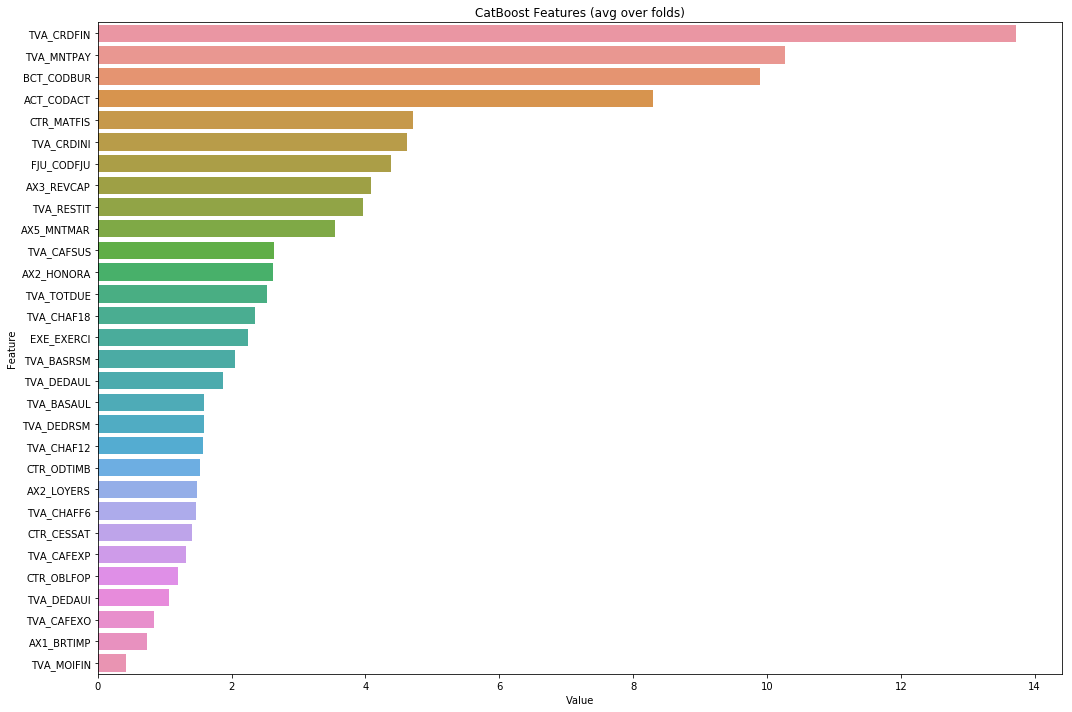

In [86]:
#used this to get the less important features that I dropped
warnings.simplefilter(action='ignore', category=FutureWarning)
feature_imp = pd.DataFrame(sorted(zip(cat.feature_importances_,train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(15, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('CatBoost Features (avg over folds)')
plt.tight_layout()
plt.show()

In [24]:
poor_feat = feature_imp.sort_values(by='Value',ascending=False).iloc[30:,1].reset_index(drop=True)

In [25]:
less_impor = list(poor_feat)

In [30]:
test.head(1)

,BCT_CODBUR,CTR_MATFIS,FJU_CODFJU,CTR_CESSAT,ACT_CODACT,CTR_OBLFOP,CTR_ODTIMB,EXE_EXERCI,TVA_CHAFF6,TVA_CHAF12,...,TVA_MOIFIN,TVA_CRDFIN,TVA_CAFEXP,TVA_CAFSUS,TVA_CAFEXO,AX1_BRTIMP,AX2_HONORA,AX2_LOYERS,AX3_REVCAP,AX5_MNTMAR
0,9,11802,99,0,6306,2,1.0,2015,0.0,14220000.0,...,12.0,0.0,0.0,0.0,0.0,0.0,14283733.0,0.0,0.0,2546400.0
